In [1]:
%matplotlib widget

import nest_asyncio
nest_asyncio.apply()


import numpy as np
import numpy.ma as ma
import math 
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.spatial import distance
import pandas as pd 
from datetime import datetime, timedelta, timezone
from netCDF4 import num2date, Dataset
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from math import sin, cos, sqrt, atan2, radians
from scipy import stats
import pygrib
import time
import os



import metpy.calc as mcalc
from metpy.units import units
from metpy.plots import SkewT
from metpy.interpolate import log_interpolate_1d
from numba import jit

np.seterr(divide='ignore', invalid='ignore')

import warnings
warnings.filterwarnings("ignore")



In [2]:
## Reading the date and time from the excel data file, then building the website name for the appropriate NAM file

## Importing data set
lst_str_cols = ['Time (UTC)']
dict_dtypes = {x : 'str'  for x in lst_str_cols}

#df           = pd.read_excel('QLCSTorClimo_update.xlsx', engine='openpyxl', dtype=dict_dtypes)
df           = pd.read_excel('./qlcs_years16_17_19_final.xlsx', engine='openpyxl', dtype=dict_dtypes)
date         = df["Date"]
times        = df["Time (UTC)"]
tor_lat      = np.array(df["Lat"])
tor_lon      = -np.absolute(np.array(df["Lon"]))
mech         = df["Mechanism"]
season       = df['Season']
ef           = df["EF Rating"]
#mon_str      = [i.strftime("%m") for i in date]
#day_str      = [i.strftime("%d") for i in date]
minute_vec   = np.array([int(i[2:4]) for i in times])

time_formal   = [i[:2] + ':' + i[2:4] for i in times]
timevec       = [datetime.strptime(i,'%H:%M') for i in time_formal]
datetime_vec  = [datetime.combine(datetime.date(date[i]), datetime.time(timevec[i])) for i in range(0, len(timevec))]
one_hr_behind = [datetime_vec[i] - timedelta(hours = 1) for i in range(0,len(datetime_vec))]

mon_str       = [i.strftime("%m") for i in datetime_vec]
day_str       = [i.strftime("%d") for i in datetime_vec]

# mon_str       = [i.strftime("%m") for i in one_hr_behind]
# day_str       = [i.strftime("%d") for i in one_hr_behind]
# hour_ahead   = np.empty(len(timevec))

# # Looping to find tornadoes that occur after the half hour mark
# for i in range(0, len(minute_vec)): 
#     if minute_vec[i]>30: 
#         timevec[i] = timevec[i] + timedelta(hours = 1)
#         hour_ahead[i] = True
#     else: 
#         timevec[i] = timevec[i]
#         hour_ahead[i] = False

          
h            = [i.strftime("%H") for i in datetime_vec]
#h            = [i.strftime("%H") for i in one_hr_behind]
year_str     = [i.strftime("%Y") for i in datetime_vec]
#year_str     = [i.strftime("%Y") for i in one_hr_behind]


month_num    = [int(i) for i in mon_str]


#clear_hsi    = df["clear"]


## RAP Format
# https://www.ncei.noaa.gov/thredds/ncss/model-rap252anl-old/201901/20190104/rap_252_20190104_1100_000.grb2/
# https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl-old/201901/20190104/rap_130_20190104_1100_000.grb2'

file_str_13 = ['https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl-old/' + year_str[i] + mon_str[i] + '/' + year_str[i] \
           + mon_str[i] + day_str[i] + '/rap_130_' + year_str[i] + mon_str[i] + day_str[i] + '_' + h[i] + '00_000.grb2'
           for i in range(0, len(mon_str))]

file_str_20 = ['https://www.ncei.noaa.gov/thredds/ncss/model-rap252anl-old/' + year_str[i] + mon_str[i] + '/' + year_str[i] \
           + mon_str[i] + day_str[i] + '/rap_252_' + year_str[i] + mon_str[i] + day_str[i] + '_' + h[i] + '00_000.grb2'
           for i in range(0, len(mon_str))]

In [3]:
# def srh_3km(gpm,p,u,v, storm_u, storm_v):
    
#     altitudes = (np.arange(10000,0,-1)*units('m')).to(units('gpm'))  #10000-50 -0
#     pressures_of_alts = np.zeros((len(altitudes), len(gpm[0,:,0]), len(gpm[0,0,:])))
#     pressures_of_alts.shape

#     for ilat in range(len(gpm[0,:,0])):
#         for ilon in range(len(gpm[0,0,:])):
#             pressures_of_alts[:, ilat, ilon] = log_interpolate_1d(altitudes, gpm[:, ilat, ilon], p.magnitude)


#     u_at_levs = units.Quantity(np.zeros((len(altitudes), len(gpm[0,:,0]), len(gpm[0,0,:]))), 'm/s')
#     v_at_levs = units.Quantity(np.zeros((len(altitudes), len(gpm[0,:,0]), len(gpm[0,0,:]))), 'm/s')

#     for ilat in range(len(gpm[0,:,0])):
#         for ilon in range(len(gpm[0,0,:])):
#             u_at_levs[:, ilat, ilon], v_at_levs[:, ilat, ilon] = log_interpolate_1d(pressures_of_alts[:, ilat, ilon],
#                                                                                     p.magnitude,
#                                                                                     u_cape[:, ilat, ilon],
#                                                                                     v_cape[:, ilat, ilon])
            
#     srh = np.zeros((len(gpm[0,:,0]), len(gpm[0,0,:])))

#     for ilat in range(len(gpm[0,:,0])):
#         for ilon in range(len(gpm[0,0,:])):
#             #[storm_u, storm_v], _, _ = mcalc.bunkers_storm_motion(units.Quantity(p, 'Pa'), u[:,ilat,ilon], v[:,ilat,ilon], gpm[:,ilat, ilon])
#             rm , lm, tot = mcalc.storm_relative_helicity(altitudes, u_at_levs[:,ilat,ilon], v_at_levs[:,ilat,ilon], depth = units.Quantity(3000, 'm'), storm_u = storm_u[ilat,ilon],  storm_v = storm_v[ilat,ilon])       
#             srh[ilat, ilon] = rm.magnitude
    
    
    
#     return u_at_levs, v_at_levs, srh

In [4]:
def get_file(file_str13, file_str20):
        
    ## Searches for RAP files given index
    ncss = None 
    cn = 0 
    file_type = 20
    
    while ncss is None: 
        try: 
            print('trying again')
            ncss = NCSS(file_str_20)
        except:
            cn+=1 
            if cn == 10: 
                ncss = 'could not find file' 
            pass
        
    return ncss, file_type
    

In [5]:
def query_data(ncss):
    query = ncss.query()
    query.all_times()
    query.variables('Convective_available_potential_energy_surface',
                        'Storm_relative_helicity_height_above_ground_layer',
                        'Convective_inhibition_surface',
                        'u-component_of_wind_isobaric',
                        'u-component_of_wind_height_above_ground',
                        'v-component_of_wind_isobaric',
                        'v-component_of_wind_height_above_ground',
                        'Composite_reflectivity_entire_atmosphere',
                        'Temperature_isobaric',
                        'Relative_humidity_isobaric', 
                        'Absolute_vorticity_isobaric', 
                        'Potential_temperature_height_above_ground', 
                        'Storm_relative_helicity_height_above_ground_layer', 
                        'Temperature_height_above_ground', 
                        'Precipitation_rate_surface')
    query.add_lonlat().lonlat_box(-135,-60,20,55)
    
    data = None 
    fn = 0
    
    while data is None: 
        try: 
            if fn==6: 
                data = 'stop_count'
            data = ncss.get_data(query)
        except:
            print('didnt work')
            fn +=1
            pass
    print('worked')
    return data

In [6]:
def ow(u,v, meters): 
    # Enter fields of u and v, returns OW parameter
    
    
    [dudy, dudx] = mcalc.gradient(u10, deltas = (units.Quantity(meters,'m'), units.Quantity(meters,'m')))
    [dvdy, dvdx] = mcalc.gradient(v10, deltas = (units.Quantity(meters,'m'), units.Quantity(meters,'m')))
    vort = mcalc.vorticity(u10, v10, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    
    
    d1 = dudx - dvdy
    d2 = dvdx + dudy
    
    
    w = d1.magnitude**2 + d2.magnitude**2 - vort.magnitude**2
    
    
    return w 
    


In [7]:
def cape_mask(cape, precip, mucape): 
    # Enter previously subsetted fields of CAPE and Precip
    cape = ma.masked_where((precip > 0.001) | (mucape<50), cape)
    return cape

    

In [8]:
def lat_lon_2D_index(y,x,lat1,lon1):
    '''This function calculates the distance from a desired 
    lat/lon point to each element of a 2D array of lat/lon values,
    typically from model output, and determines the index value 
    corresponding to the nearest lat/lon grid point.
    
    x = longitude array
    y = latitude array
    lon1 = longitude point (single value)
    lat1 = latitude point (single value)
    
    Returns the two index values for nearest lat, lon 
    point on grid for grids (y,x)
    
    Equations for variable distance between longitudes from
    http://andrew.hedges.name/experiments/haversine/'''
    
    R = 6373.*1000.  # Earth's Radius in meters
    rad = np.pi/180.
    x1 = np.ones(x.shape)*lon1
    y1 = np.ones(y.shape)*lat1
    dlon = np.abs(x-x1)
    dlat = np.abs(y-y1)
    a = (np.sin(rad*dlat/2.))**2 + \
         np.cos(rad*y1) * np.cos(rad*y) * (np.sin(rad*dlon/2.))**2 
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
    d = R * c
    return np.unravel_index(d.argmin(), d.shape)

In [9]:
def coord_plus_d(lat1,lon1, d, brng):
    R = 6378.1
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    brng = math.radians(brng)
    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
     math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    
    return lat2, lon2

In [10]:
def angle_between(lat1, lon1, lat2, lon2):
    
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    
    dLon = math.radians(np.abs(lon2-lon1))
    
    
    x = math.sin(dLon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dLon);
    
    brng = math.atan2(x,y)
    brng = math.degrees(brng);
    brng = (brng + 360) % 360;
    #brng = 360 - brng; 

    return brng

In [11]:
def fbox(comp_r, torlat, torlon, lat, lon):
    
    d = 200
    comp_r_smooth = ndimage.gaussian_filter(comp_r, sigma=3.0, order=0)

    c_rad = np.argwhere(comp_r_smooth[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10] > np.max(comp_r_smooth[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10])-10)

    box_lat = lat[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10]
    box_lon = lon[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10]


    where_lat = [box_lat[i[0], i[1]] for i in c_rad]
    where_lon = [box_lon[i[0], i[1]] for i in c_rad]

    coord_list = [(where_lat[i], where_lon[i]) for i in range(0,len(where_lat))]
    dists = distance.cdist(coord_list, coord_list, 'euclidean')

    max_pind = np.argwhere(dists == np.max(dists))[0]

    mtp1 = coord_list[max_pind[0]]
    mtp2 = coord_list[max_pind[1]]

    brng = angle_between(mtp1[0],mtp1[1],mtp2[0],mtp2[1])
    
    #[dlon, dlon] = coord_plus_d(model_tor_lat,model_tor_lon, 100, brng+90)
    [lat1, lon1] = coord_plus_d(model_tor_lat,model_tor_lon, d/2, brng)
    [lat2, lon2] = coord_plus_d(lat1,lon1, d, brng-90)
    [lat3, lon3] = coord_plus_d(lat2,lon2, d, brng-180)
    [lat4, lon4] = coord_plus_d(lat3,lon3, d, brng-270)
    
    xlat = np.max([lat1,lat2,lat3,lat4])
    nlat = np.min([lat1,lat2,lat3,lat4])
    
    xlon = np.max([lon1,lon2,lon3,lon4])
    nlon = np.min([lon1,lon2,lon3,lon4])
    
    xx = lat_lon_2D_index(lat,lon, xlat, xlon)
    xn = lat_lon_2D_index(lat,lon, xlat, nlon)
    nx = lat_lon_2D_index(lat,lon, nlat, xlon)
    nn = lat_lon_2D_index(lat,lon, nlat, nlon)
    
    inds = (xx, xn, nx, nn)
    
    nlat_ind = np.min([i[0] for i in inds])
    xlat_ind = np.max([i[0] for i in inds])
    
    nlon_ind = np.min([i[1] for i in inds])
    xlon_ind = np.max([i[1] for i in inds])
    
    return  nlat_ind, xlat_ind, nlon_ind, xlon_ind #xlat, nlat, xlon, nlon 
    
    


In [12]:
def calc_srh(u_p, v_p, z_p, p_profile, gpm_surface, p_surface, u_surface, v_surface, depth):
    
    srh = np.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0, len(gpm_surface[0,:])):
                surf = gpm_surface[ilat,ilon]
                gpm = z_p[:,ilat,ilon]-surf
                above_ground = np.where(gpm>units.Quantity(50,'m'))


                u = u_p[:,ilat,ilon][above_ground]
                v = v_p[:,ilat,ilon][above_ground]
                p = p_profile[above_ground]
                gpm = gpm[above_ground]

                if p_surface[ilat, ilon] > p[0]: 
                    gpm = np.insert(gpm, 0,0)
                    u   = np.insert(u, 0, u_surface[ilat,ilon])
                    v   = np.insert(v, 0, v_surface[ilat,ilon])
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('srh')
                
                #print(gpm)

                [rm,_,mean] = mcalc.bunkers_storm_motion(units.Quantity(np.array(p), 'Pa'), units.Quantity(np.array(u),'m/s'),units.Quantity(np.array(v),'m/s'),units.Quantity(np.array(gpm),'gpm'))
                [srh_rm,srh_lm,tot] = mcalc.storm_relative_helicity(units.Quantity(np.array(gpm),'gpm'),  units.Quantity(np.array(u),'m/s'),units.Quantity(np.array(v),'m/s'), depth = units.Quantity(depth, 'm'), storm_u = rm[0], storm_v = rm[1])
                srh[ilat, ilon] = srh_rm.magnitude
    return srh

In [13]:
def calc_lcl_height(z_p, gpm_s, t_s, rh_s, p_s, p_profile): 
    
    td_s = mcalc.dewpoint_from_relative_humidity(t_s,  np.array(rh_s))

    lcl_p, lcl_t = mcalc.lcl(units.Quantity(np.array(p_s),'Pa'), units.Quantity(np.array(t_s), 'K'), units.Quantity(np.array(td_s),'degC'))

    lcl_height = ma.zeros((len(gpm_s[:,0]), len(gpm_s[0,:])))

    for ilat in range(0,len(gpm_s[:,0])):
        for ilon in range(0,len(gpm_s[0,:])):
                    surf_height = gpm_s[ilat,ilon]
                    gpm  = z_p[:,ilat,ilon]-surf_height
                    
                    #print(gpm)
                    above_ground = np.where(gpm>units.Quantity(50,'m'))
                    gpm = gpm[above_ground]
                    p_prof = p_profile[above_ground]
#                     print(p_prof)
#                     print(p_s[ilat,ilon])
                    
                    # append surface observation to the bottom of array
                    if p_s[ilat, ilon] > p_prof[0]: 
                        p_prof   = np.insert(p_prof, 0, p_s[ilat,ilon])
                        gpm = np.insert(0,0, gpm)
                    else: 
                        print('***Possible sounding error***')
                        print('lcl')
                        
                    #print(p_s[ilat,ilon]-p_prof[0])

                    lcl_height[ilat, ilon] = log_interpolate_1d(lcl_p[ilat,ilon].magnitude, p_prof.magnitude,  gpm.magnitude)
                    #print(lcl_height[ilat,ilon])
                    
#                     if np.isnan(lcl_height[ilat,ilon]):
#                         print(p_prof[0])
#                         print(p_s[ilat,ilon])
#                         print(lcl_p[ilat,ilon])
                    
    return lcl_height  #, td_s, t_s, gpm

In [14]:
def calc_bulk_shear(u_p, v_p, z_p, p_profile, gpm_surface, p_surface, u_surface, v_surface, depth):
    
    u_bulk = np.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    v_bulk = np.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    
    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0, len(gpm_surface[0,:])):
                surf = gpm_surface[ilat,ilon]
                gpm = z_p[:,ilat,ilon]-surf
                above_ground = np.where(gpm>units.Quantity(50,'m'))


                u = u_p[:,ilat,ilon][above_ground]
                v = v_p[:,ilat,ilon][above_ground]
                p = p_profile[above_ground]
                gpm = gpm[above_ground]
                
                if p_surface[ilat, ilon] > p[0]: 
                    gpm = np.insert(gpm, 0,0)
                    u   = np.insert(u, 0, u_surface[ilat,ilon])
                    v   = np.insert(v, 0, v_surface[ilat,ilon])
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('blk')

                [u_bs, v_bs] = mcalc.bulk_shear(units.Quantity(np.array(p),'Pa'), units.Quantity(np.array(u), 'm/s'),\
                                                units.Quantity(np.array(v),'m/s'), height = units.Quantity(np.array(gpm),'gpm'),\
                                                depth=units.Quantity(depth,'m'))
                
                u_bulk[ilat, ilon] = u_bs.magnitude
                v_bulk[ilat, ilon] = v_bs.magnitude
                #print(u_bs)
    return u_bulk, v_bulk

In [15]:

def calc_mucape(t_p, rh_p, z_p, p_profile, gpm_surface, p_surface, t_surface, rh_surface): 
    
    ## ****************************Should also be adding in a surface ob too **************************************
    MUCAPE = np.zeros((len(rh_p[0,:,0]), len(rh_p[0, 0,:])))
    MUCIN  = np.zeros((len(rh_p[0,:,0]), len(rh_p[0, 0,:])))

    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                surf_height = gpm_surface[ilat,ilon]
                
                gpm  = z_p[:,ilat,ilon]-surf_height
                above_ground = np.where(gpm>units.Quantity(50,'m'))

                # Above Ground 
                T  = t_p[:,ilat,ilon][above_ground]

                Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon][above_ground]))

                Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
                p = p_profile[above_ground]
                gpm = gpm[above_ground]

                if p_surface[ilat, ilon] > p[0]: 
                    gpm = np.insert(gpm, 0,0)
                    T   = np.insert(T, 0, t_surface[ilat,ilon])
                    Td  = np.insert(Td, 0, Td_surf)
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('mucape')
                [mucape, mucin]   = mcalc.most_unstable_cape_cin(units.Quantity(np.array(p), 'Pa'),\
                                                                 units.Quantity(np.array(T), 'K'),\
                                                                 units.Quantity(np.array(Td), 'degC'))
                
                MUCAPE[ilat,ilon] = mucape.magnitude
                MUCIN[ilat,ilon]  = mucin.magnitude

    return MUCAPE, MUCIN


In [16]:
def calc_sbcape(t_p, rh_p, z_p, p_profile, gpm_surface, p_surface, t_surface, rh_surface):
    
    ## Must feed in pint.Quantity because metPy thinks I can't handle units on my own
    
    start_init = time.time()
    sbCAPE = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    sbCIN  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    end_init   = time.time()
    
    #print('init time = ', end_init-start_init)
    
    
    
    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                
                start_mask = time.time()
                surf_height = gpm_surface[ilat,ilon]
                gpm  = z_p[:,ilat,ilon]-surf_height
                above_ground = np.where(gpm>units.Quantity(50,'m'))
                end_mask = time.time()
                
                #print('mask time =', end_mask-start_mask)
                
                
                # Above Ground 
                
                Td_start = time.time()
                T  = t_p[:,ilat,ilon][above_ground]
                Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon][above_ground]))
                Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
                Td_end   = time.time()
                
                #print('Td time = ', Td_end-Td_start)
                p = p_profile[above_ground]
                gpm = gpm[above_ground]

# adding surface observations
                
                if p_surface[ilat, ilon] > p[0]: 
                    gpm = np.insert(gpm, 0,0)
                    T   = np.insert(T, 0, t_surface[ilat,ilon])
                    Td  = np.insert(Td, 0, Td_surf)
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('sbcape')

                [sbcape, sbcin]   = mcalc.surface_based_cape_cin(units.Quantity(np.array(p), 'Pa'),\
                                                                 units.Quantity(np.array(T), 'K'),\
                                                                 units.Quantity(np.array(Td), 'degC'))
                #print('cape_time = ', end_cape-start_cape)
                sbCAPE[ilat,ilon] = sbcape.magnitude
                sbCIN[ilat,ilon]  = sbcin.magnitude

    return sbCAPE, sbCIN

In [17]:
def calc_3kcape(t_p, rh_p, z_p, p_profile, gpm_surface, p_surface, t_surface, rh_surface):

    ## Must feed in pint.Quantity because metPy thinks I can't handle units on my own

    three_CAPE = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    three_CIN  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                surf_height = gpm_surface[ilat,ilon]

                gpm  = z_p[:,ilat,ilon]-surf_height
                between = np.where((gpm>units.Quantity(50,'m')) & (gpm<units.Quantity(3000, 'm')))


                # Subsetting 
                T  = t_p[:,ilat,ilon][between]
                Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon][between]))

                Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
                p = p_profile[between]
                gpm = gpm[between]

                # adding surface observations

                if p_surface[ilat, ilon] > p[0]: 
                    gpm = np.insert(gpm, 0,0)
                    T   = np.insert(T, 0, t_surface[ilat,ilon])
                    Td  = np.insert(Td, 0, Td_surf)
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('3kcape')

                
                try:
                    [three_cape, three_cin]   = mcalc.surface_based_cape_cin(units.Quantity(np.array(p), 'Pa'),\
                                                                 units.Quantity(np.array(T), 'K'),\
                                                                 units.Quantity(np.array(Td), 'degC'))
                except: 
                    three_cape = units.Quantity(0, 'J/kg')
                    three_cin = units.Quantity(0, 'J/kg')
                    
                three_CAPE[ilat,ilon] = three_cape.magnitude
                three_CIN[ilat,ilon]  = three_cin.magnitude

    return three_CAPE, three_CIN

In [18]:
# def calc_3kcape(t_p, rh_p, z_p, p_profile, gpm_surface, p_surface, t_surface, rh_surface):
    
#     ## Must feed in pint.Quantity because metPy thinks I can't handle units on my own
    
#     three_CAPE = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
#     three_CIN  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

#     for ilat in range(0,len(gpm_surface[:,0])):
#             for ilon in range(0,len(gpm_surface[0,:])):
#                 surf_height = gpm_surface[ilat,ilon]
                
#                 gpm  = z_p[:,ilat,ilon]-surf_height
            
                
#                 T  = t_p[:,ilat,ilon]
#                 Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon]))
                
#                 Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
#                 p_new = p_profile
                
#                 above_ground = np.where(gpm > units.Quantity(0,'m'))
                
#                 gpm = gpm[above_ground]
#                 T   = T[above_ground]
#                 Td  = Td[above_ground]
#                 p_new   = p[above_ground]

#                 # adding surface observations

#                 gpm = np.insert(gpm, 0,0)
#                 T   = np.insert(T, 0, t_surface[ilat,ilon])
#                 Td  = np.insert(Td, 0, Td_surf)
#                 p_new   = np.insert(p_new, 0, p_surface[ilat,ilon])
                
#                 #print(p_surface[ilat,ilon])
                
#                 agl = np.linspace(0,3000,1000)
                
#                 p_interp, t_interp, td_interp = log_interpolate_1d(agl, gpm.magnitude, p_new, T, Td)
                
#                 print(p_interp)
#                 print(t_interp)
#                 print(td_interp)
                
                
#                 [three_cape, three_cin] = mcalc.surface_based_cape_cin(units.Quantity(np.array(p_interp), 'Pa'),\
#                                                                  units.Quantity(np.array(t_interp), 'K'),\
#                                                                  units.Quantity(np.array(td_interp), 'degC'))
#                 three_CAPE[ilat,ilon] = three_cape.magnitude
#                 three_CIN[ilat,ilon]  = three_cin.magnitude

#     return three_CAPE, three_CIN

In [19]:
def calc_mlcape(t_p, rh_p, z_p, p_profile, gpm_surface, p_surface, t_surface, rh_surface):
    
    ## Must feed in pint.Quantity because metPy thinks I can't handle units on my own
    
    mlCAPE = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    mlCIN  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                surf_height = gpm_surface[ilat,ilon]
                
                gpm  = z_p[:,ilat,ilon]-surf_height
                above_ground = np.where(gpm>units.Quantity(50,'m'))

                # Above Ground 
                T  = t_p[:,ilat,ilon][above_ground]
                Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon][above_ground]))

                Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
                p = p_profile[above_ground]
                gpm = gpm[above_ground]

# adding surface observations

                
                if p_surface[ilat, ilon] > p[0]: 
                    gpm = np.insert(gpm, 0,0)
                    T   = np.insert(T, 0, t_surface[ilat,ilon])
                    Td  = np.insert(Td, 0, Td_surf)
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('mlcape')
                
                [mlcape, mlcin]   = mcalc.mixed_layer_cape_cin(units.Quantity(np.array(p), 'Pa'),\
                                                                 units.Quantity(np.array(T), 'K'),\
                                                                 units.Quantity(np.array(Td), 'degC'))
#                 
                mlCAPE[ilat,ilon] = mlcape.magnitude
                mlCIN[ilat,ilon]  = mlcin.magnitude


    return mlCAPE, mlCIN

In [20]:
def calc_LR(t_p, z_p, p_profile, gpm_surface, t_surface, bot_height, height):
    ## Lapse rate tests

    LR  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                
                surf_height = gpm_surface[ilat,ilon]

                gpm  = z_p[:,ilat,ilon]-surf_height
                #layer = np.where((gpm>units.Quantity(50,'m')) & (gpm<units.Quantity(height, 'm')))
                #t     = t_p[:,ilat,ilon]

                hgt = units.Quantity(height,'m')
                bhgt = units.Quantity(bot_height, 'm')

                km_temp = log_interpolate_1d(hgt, gpm, t_p[:,ilat,ilon])

                #p_test = p_profile[layer]
                #gpm = gpm[layer]
                #t   = t_test[:,ilat,ilon][layer]

                # adding surface observations

    #             gpm = np.insert(gpm, 0,0)
    #             T   = np.insert(t, 0, t_surface[ilat,ilon])
                if bot_height!=0: 
                    bot_temp = log_interpolate_1d(bhgt, gpm, t_p[:,ilat,ilon])
                else:
                    bot_temp = t_surface[ilat,ilon]
                LR[ilat, ilon] = (-(km_temp-bot_temp)/(height/1000)).magnitude
                #print(km_temp)
        
    return LR

In [21]:
def calc_nst(lr01, mlcape03, mlcin, bs06, vort): 
    mult1  = lr01/9 
    mult2  = mlcape03/100
    mult3  = (225-mlcin)/200
    mult4  = (18-bs06)/5
    mult5  = (vort/(8*10**-5))
    
    return mult1*mult2*mult3*mult4*mult5

In [22]:
def calc_rh03(rh_p, rh_surf, p_prof, z_p, p_surface, gpm_surface): 
    
    rh03 = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    
    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                agl = z_p[:, ilat, ilon] - gpm_surface[ilat,ilon]
                
                above_ground = np.where(agl >units.Quantity(50,'m'))
                rh  = rh_p[:,ilat,ilon][above_ground]
                p = p_prof[above_ground]
                agl = agl[above_ground]
                
                                        
                ## Surface data
                
                if p_surface[ilat, ilon] > p[0]: 
                    agl = np.insert(agl, 0,0)
                    rh   = np.insert(rh, 0, rh_surf[ilat,ilon])
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('***Possible sounding error***')
                    print('rh03')
                
#                 rh_03 = mcalc.mean_pressure_weighted(units.Quantity(p, 'Pa'), rh, units.Quantity(agl,'m'), units.Quantity(0,'m')\
#                                                     , depth = units.Quantity(3000, 'm'))

                #rh_03 = mcalc.mean_pressure_weighted(units.Quantity(p, 'Pa'), np.array(rh))
                rh_03 = mcalc.mean_pressure_weighted(units.Quantity(np.array(p),'Pa'), units.Quantity(np.array(rh), 'm/m'), \
                                             height = agl, depth = units.Quantity(3000,'m'))
                rh03[ilat,ilon] = rh_03[0].magnitude
    return rh03


In [23]:
def calc_rh36(rh_p, rh_surf, p_prof, z_p, p_surface, gpm_surface): 
    
    rh36 = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
    
    for ilat in range(0,len(gpm_surface[:,0])):
            for ilon in range(0,len(gpm_surface[0,:])):
                agl = z_p[:, ilat, ilon] - gpm_surface[ilat,ilon]
                
                above_ground = np.where(agl >units.Quantity(50,'m'))
                rh  = rh_p[:,ilat,ilon][above_ground]
                p = p_prof[above_ground]
                agl = agl[above_ground]
                
                
                ## Surface data
                if p_surface[ilat, ilon] > p[0]: 
                    agl = np.insert(agl, 0,0)
                    rh   = np.insert(rh, 0, rh_surf[ilat,ilon])
                    p   = np.insert(p, 0, p_surface[ilat,ilon])
                else: 
                    print('rh06')
                
#                 rh_03 = mcalc.mean_pressure_weighted(units.Quantity(p, 'Pa'), rh, units.Quantity(agl,'m'), units.Quantity(0,'m')\
#                                                     , depth = units.Quantity(3000, 'm'))

                #rh_03 = mcalc.mean_pressure_weighted(units.Quantity(p, 'Pa'), np.array(rh))
                rh_36 = mcalc.mean_pressure_weighted(units.Quantity(np.array(p),'Pa'), units.Quantity(np.array(rh), 'm/m'), \
                                             height = agl, bottom = units.Quantity(3000, 'm'), depth = units.Quantity(3000,'m'))
                rh36[ilat,ilon] = rh_36[0].magnitude
    return rh36

In [24]:
def mean_median_max_pt(field, lat_indi, lon_indi):
    ## Given a 2D field
    
    field = ma.array(field)
    
    mn = ma.mean(field)
    md = ma.median(field)
    mx = ma.max(field)
    pt = field[lat_indi, lon_indi]

    return ma.array([mn,md,mx, pt])

In [25]:
def mean_median_min_pt(field, lat_indi, lon_indi):
    ## Given a 2D field
    
    field = ma.array(field)
    
    mn = ma.mean(field)
    md = ma.median(field)
    mx = ma.min(field)
    pt = field[lat_indi, lon_indi]

    return ma.array([mn,md,mx, pt])

In [26]:
if os.path.isfile('Rap_Obs_prelim_final_g.npz'): 
    past_dat = np.load('Rap_Obs_prelim_final6.npz', allow_pickle = True)

    
    n_points    = past_dat['n_points']
    start_point = past_dat['start_point']
    nskip       = past_dat['nskip']
    tor_dates   = past_dat['tor_dates']
    tor_times   = past_dat['tor_times']
    tor_mech    = past_dat['tor_mech']
    
    sbcape      = past_dat['sbcape']
    sbcape_model = past_dat['sbcape_model']
    sbcin       = past_dat['sbcin']
    mucape      = past_dat['mucape']
    mucin       = past_dat['mucin']
    mlcape      = past_dat['mlcape']
    mlcin       = past_dat['mlcin']
    threecape   = past_dat['threecape']
    threecin    = past_dat['threecin']
    hsi_sbcape  = past_dat['hsi_sbcape']
    tas_sbcape  = past_dat['tas_sbcape']
    
    lr01        = past_dat['lr01']
    lr03        = past_dat['lr03']
    lr36        = past_dat['lr36']
    rh03        = past_dat['rh03']
    rh36        = past_dat['rh36']
    
    srh03       = past_dat['srh03']
    srh01       = past_dat['srh01']
    bs01        = past_dat['bs01']
    bs03        = past_dat['bs03']
    bs06        = past_dat['bs06']
    
    lcl         = past_dat['lcl']
    stp         = past_dat['stp']
    scp         = past_dat['scp']
    nst         = past_dat['nst']
    
    vort            = past_dat['vort']
    vort_area       = past_dat['vort_area']
    vort_925        = past_dat['vort_925']
    vort_area_925   = past_dat['vort_area_925']
    vort_850        = past_dat['vort_850']
    vort_area_850   = past_dat['vort_area_850']
    vort_700        = past_dat['vort_700']
    vort_area_700   = past_dat['vort_area_700']
    
    fgen            = past_dat['fgen']
    fgen_area       = past_dat['fgen_area']
    fgen_925        = past_dat['fgen_925']
    fgen_area_925   = past_dat['fgen_area_925']
    fgen_850        = past_dat['fgen_850']
    fgen_area_850   = past_dat['fgen_area_850']
    fgen_700        = past_dat['fgen_700']
    fgen_area_700   = past_dat['fgen_area_700']
    
    div             = past_dat['div']
    div_area        = past_dat['div_area']
    div_850         = past_dat['div_850']
    div_area_850    = past_dat['div_area_850']
    div_700         = past_dat['div_700']
    div_area_700    = past_dat['div_area_700']
    
    cool_indices = past_dat['cool_indices']
    warm_indices = past_dat['warm_indices']
    hsi_indices = past_dat['hsi_indices']
    tas_indices = past_dat['tas_indices']
    other_indices = past_dat['other_indices']
    tor_index   = past_dat['tor_index']
    
    
    dum_fn = ''
    
    ## Reshaping data
#     cool_hsi = np.intersect1d(cool_indices, hsi_indices).astype(int)
#     warm_hsi = np.intersect1d(warm_indices, hsi_indices).astype(int)

#     warm_tas = np.intersect1d(warm_indices, tas_indices).astype(int)
#     cool_tas = np.intersect1d(cool_indices, tas_indices).astype(int)

#     sbcape = np.reshape(sbcape, (-1,4))
#     sbcin  = np.reshape(sbcin, (-1,4))
#     mucape = np.reshape(mucape, (-1,4))
#     mucin  = np.reshape(mucin, (-1, 4))
#     mlcape = np.reshape(mlcape, (-1, 4))
#     mlcin  = np.reshape(mlcin, (-1, 4))
#     threecape = np.reshape(threecape, (-1,4))
#     lr01   = np.reshape(lr01,  (-1, 4))
    
#     lcl    = np.reshape(lcl,   (-1,4))
#     stp    = np.reshape(stp,   (-1, 4))
#     scp    = np.reshape(scp,   (-1, 4))
#     nst    = np.reshape(nst,   (-1, 4))

#     bs01 = np.reshape(bs01, (-1,4))
#     bs03 = np.reshape(bs03, (-1,4))
#     bs06 = np.reshape(bs06, (-1,4))
#     srh01 = np.reshape(srh01, (-1,4))
#     srh03 = np.reshape(srh03, (-1,4))

    ## Masking Data
    stp = ma.masked_where(np.isnan(stp), stp)
    mlcape = ma.masked_where(np.isnan(mlcape), mlcape)
    mlcin = ma.masked_where(np.isnan(mlcin), mlcin)
    sbcape = ma.masked_where(np.isnan(sbcape), sbcape)
    sbcin = ma.masked_where(np.isnan(sbcin), sbcin)
    threecape = ma.masked_where(np.isnan(threecape), threecape)
    mucape = ma.masked_where(np.isnan(mucape), mucape)
    mucin = ma.masked_where(np.isnan(mucin), mucin)
    lr01  = ma.masked_where(np.isnan(lr01), lr01)
    lr03  = ma.masked_where(np.isnan(lr03), lr03)
    lr36  = ma.masked_where(np.isnan(lr36), lr36)
    
    rh03  = ma.masked_where(np.isnan(rh03), rh03)
    rh36  = ma.masked_where(np.isnan(rh03), rh36)
    sbcape_model = ma.masked_where(np.isnan(sbcape_model), sbcape_model)
    
    lcl = ma.masked_where(np.isnan(lcl), lcl)
    scp = ma.masked_where(np.isnan(scp), scp)
    nst = ma.masked_where(np.isnan(nst), nst)
    
    bs01 = ma.masked_where(np.isnan(bs01), bs01)
    bs03 = ma.masked_where(np.isnan(bs03), bs03)
    bs06 = ma.masked_where(np.isnan(bs06), bs06)

    srh01= ma.masked_where(np.isnan(srh01), srh01)
    srh03= ma.masked_where(np.isnan(srh03), srh03)
    
    hsi_sbcape = ma.masked_where(np.isnan(hsi_sbcape), hsi_sbcape)
    tas_sbcape = ma.masked_where(np.isnan(tas_sbcape), tas_sbcape)
    
else: 
    sbcape   = ma.array([])
    sbcin    = ma.array([])
    threecape = ma.array([])
    threecin  = ma.array([])
    mucape   = ma.array([])
    mucin    = ma.array([])
    rap_cape = ma.array([])
    rap_cin  = ma.array([])
    mlcape   = ma.array([])
    mlcin    = ma.array([])
    sbcape_model = ma.array([])
    
    lr01     = ma.array([])
    lr03     = ma.array([])
    lr36     = ma.array([])
    rh03     = ma.array([])
    rh36     = ma.array([])
    
    srh03    = ma.array([])
    srh01    = ma.array([])
    
    bs01     = ma.array([])
    bs03     = ma.array([])
    bs06     = ma.array([])
    
    lcl      = ma.array([])
    stp      = ma.array([])
    scp      = ma.array([])
    nst      = ma.array([])
    
    
    n_points = ma.array([])
    
    ## Larger domain 
    
    vort = np.array([])
    fgen = np.array([])
    div  = np.array([])
    
    vort_925        = np.array([])
    vort_area_925   = np.array([])
    vort_850        = np.array([])
    vort_area_850   = np.array([])
    vort_700        = np.array([])
    vort_area_700   = np.array([])
    
    vort_area       = np.array([])
    fgen_area       = np.array([])
    div_area        = np.array([])
    
    fgen_925        = np.array([])
    fgen_area_925   = np.array([])
    fgen_850        = np.array([])
    fgen_area_850   = np.array([])
    fgen_700        = np.array([])
    fgen_area_700   = np.array([])
    
    div_850         = np.array([])
    div_area_850    = np.array([])
    div_700         = np.array([])
    div_area_700    = np.array([])

    cool_indices    = np.array([])
    warm_indices    = np.array([])
    
    hsi_indices     = np.array([])
    tas_indices     = np.array([])
    other_indices   = np.array([])
    
    tor_dates       = np.array([])
    tor_times       = np.array([])
    tor_mech        = np.array([])
    
    hsi_sbcape = ma.array([])
    tas_sbcape = ma.array([])
    
    start_point = 0
    nskip = 0 
    dum_fn = ''
    tor_index = 0

In [27]:
start_point

0

In [28]:
file_str_13[133]

'https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl-old/201905/20190527/rap_130_20190527_0500_000.grb2'

In [29]:
n_test = 0
data_counter = 0

start = time.time()

for i in range(start_point, len(file_str_13)): #start_point, len(file_str_13)): #40,45):  ## 219, good example of sb vs mu cape
    print(mech[i])
    case_mech = mech[i]

    #print(file_str_13[i])
    
#     if file_str_13[i] == dum_fn: 
#         print('skipping case due to same environment')
#         nskip += 1
#         start_point += 1
#         continue 
    ncss = None
    cn = 0
    rap_res = 13
    srt_time = time.time()
    
    while ncss is None:
        try: 
            ncss = NCSS(file_str_13[i])
        except:
            cn+=1
            print('trying again')
            print(time.time()-srt_time)
            if ((cn == 20)): 
                ncss = 'could not find file' 
            pass
    
    if ncss == 'could not find file':
        print('could not find file '  + str(i))
        start_point += 1 
        nskip += 1
        continue
        
#     ncss = NCSS(file_str_20[i])
#     rap_res = 20

    query = ncss.query()
    query.all_times()
    query.variables('Convective_available_potential_energy_surface',
                        'Storm_relative_helicity_height_above_ground_layer',
                        'Convective_inhibition_surface',
                        'u-component_of_wind_isobaric',
                        'u-component_of_wind_height_above_ground',
                        'v-component_of_wind_isobaric',
                        'v-component_of_wind_height_above_ground',
                        'Temperature_isobaric',
                        'Relative_humidity_isobaric', 
                        'Absolute_vorticity_isobaric', 
                        'Potential_temperature_height_above_ground', 
                        'Storm_relative_helicity_height_above_ground_layer', 
                        'Temperature_height_above_ground',
                        'Relative_humidity_height_above_ground',
                        'Precipitation_rate_surface', 
                        'Geopotential_height_isobaric', 
                        'Geopotential_height_surface', 
                        'Pressure_surface',
                        'Reflectivity_height_above_ground',
                        'Composite_reflectivity_entire_atmosphere')
    
    query.add_lonlat().lonlat_box(tor_lon[i]-5,tor_lon[i]+5,tor_lat[i]-5 , tor_lat[i]+5)
    
    print('Using the ' + str(rap_res) + 'km RAP')
    fn = 0 
    data = None
          
    while data is None: 
        try: 
            if fn==20: 
                data = 'stop_count'
            data = ncss.get_data(query)
        except:
            print('didnt work')
            fn +=1
            pass
    print('worked')

    
    if data == 'stop_count':
        print('Stopped analysis after tornado #'  + str(i))
        break
        
     
        
    dtime    = data['Convective_available_potential_energy_surface'].dimensions[0]
    dz       = data['u-component_of_wind_height_above_ground'].dimensions[1]
    dz_theta = data['Potential_temperature_height_above_ground'].dimensions[1]
    dz_srh   = data['Storm_relative_helicity_height_above_ground_layer'].dimensions[1]
    dz_tp     = data['Temperature_isobaric'].dimensions[0]
     
    start_point += 1
    t = data.variables[dtime][:]
    lat  = data.variables['lat'][:]
    lon  = data.variables['lon'][:]
    z    = data.variables[dz][:]
    z_theta = data.variables[dz_theta][:]
    z_srh   = data.variables[dz_srh][:]
    
    ## Finding the lat-lon indices closest to TG
    lat_ind, lon_ind = lat_lon_2D_index(lat,lon, tor_lat[i], tor_lon[i])
    
    model_tor_lat = lat[lat_ind,lon_ind]
    model_tor_lon = lon[lat_ind,lon_ind]

    ## Creating a box surrounding the tornado for the CAPE analysis, 13km RAP
    if rap_res == 13:         ## CAPE box is 117km on sides, FGEN box is 260km on sides  
        area = 169
        meters = 13000
        
        blat = lat_ind - 5
        tlat = lat_ind + 6
        blon = lon_ind - 4
        tlon = lon_ind + 7
        
        fblat = lat_ind-10
        ftlat = lat_ind+11
        fblon = lon_ind-19
        ftlon = lon_ind+2
    
    
    ## Creating a box for the frontogenesis calculation, 20km RAP 
    if rap_res == 20:        ## CAPE box is 120km on sides, FGEN box is 260km on sides 
        area = 400
        meters = 20000
        
        blat = lat_ind - 3
        tlat = lat_ind + 3
        blon = lon_ind - 2
        tlon = lon_ind + 4
        
        fblat = lat_ind-7
        ftlat = lat_ind+6
        fblon = lon_ind-12
        ftlon = lon_ind+1
    
    # Variables
    sb_cape_model = data.variables['Convective_available_potential_energy_surface'][:].squeeze()
    sbcin_model  = data.variables['Convective_inhibition_surface'][:].squeeze()
    
    abs_vort    = data.variables['Absolute_vorticity_isobaric'][0,0,:,:]
    precip      = data.variables['Precipitation_rate_surface'][:].squeeze()
    model_srh   = data.variables['Storm_relative_helicity_height_above_ground_layer'][:].squeeze()
    
    #sbC = sbCIN[blat:tlat, blon:tlon]
    
    p    = data['isobaric'][:]
    p    = p[::-1]
    p    = units.Quantity(p, "Pa")
    
    index_925 = np.where(p.magnitude == 92500.0)[0][0]
    index_850 = np.where(p.magnitude == 85000.0)[0][0]
    index_700 = np.where(p.magnitude == 70000.0)[0][0]
    
    ## Calculating potential temperature
    pot_temp  = data['Potential_temperature_height_above_ground'][0,0,:,:]#units.Quantity(np.array([t_isobaric[i,:,:]*(100000/p[i])**(0.286) for i in range(0,len(p))]), 'K')
    pot_temp = units.Quantity(pot_temp, 'K')
    
    ## Winds vs Pressure
    u_p  =  units.Quantity(data['u-component_of_wind_isobaric'][:].squeeze()[::-1,:,:],'m/s')
    v_p  =  units.Quantity(data['v-component_of_wind_isobaric'][:].squeeze()[::-1,:,:],'m/s')
    
    u925 = u_p[index_925,:,:]
    u850 = u_p[index_850,:,:]
    u700 = u_p[index_700,:,:]
    
    v925 = v_p[index_925,:,:]
    v850 = v_p[index_850,:,:]
    v700 = v_p[index_700,:,:]
    
    
    ## Heights (gpm) vs Pressure
    z_p = units.Quantity(data['Geopotential_height_isobaric'][:].squeeze()[::-1,:,:],'gpm')
    
    ## Temperature and RH vs Pressure (K, %)
    t_p  = units.Quantity(data.variables['Temperature_isobaric'][:].squeeze()[::-1,:,:],'K')
    rh_p = data['Relative_humidity_isobaric'][:].squeeze()[::-1,:,:]/100
    
    pot_temp_925 = mcalc.potential_temperature(units.Quantity(92500, 'Pa'), units.Quantity(t_p[index_925,:,:], 'K'))
    pot_temp_850 = mcalc.potential_temperature(units.Quantity(85000, 'Pa'), units.Quantity(t_p[index_850,:,:], 'K'))
    pot_temp_700 = mcalc.potential_temperature(units.Quantity(70000, 'Pa'), units.Quantity(t_p[index_700,:,:], 'K'))
    
    
    # Surface winds (m/s)
    u10  = units.Quantity(data['u-component_of_wind_height_above_ground'][:].squeeze()[0,:,:],'m/s')
    v10  = units.Quantity(data['v-component_of_wind_height_above_ground'][:].squeeze()[0,:,:],'m/s')
    
    # Surface Fields
    gpm_surface = units.Quantity(data['Geopotential_height_surface'][:].squeeze(),'gpm')
    p_surface   = units.Quantity(data['Pressure_surface'][:].squeeze(),'Pa')
    rh_surface  = data['Relative_humidity_height_above_ground'][:].squeeze()/100
    t_surface   = units.Quantity(data['Temperature_height_above_ground'][:].squeeze()[0,:,:],'K')
    
    
    ## Calculating average layer Relative Humidity
        
    rh_03 = calc_rh03(rh_p[:,blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon], p, z_p[:,blat:tlat,blon:tlon],\
                p_surface[blat:tlat,blon:tlon], gpm_surface[blat:tlat,blon:tlon])
    
    rh_36 = calc_rh36(rh_p[:,blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon], p, z_p[:,blat:tlat,blon:tlon],\
                p_surface[blat:tlat,blon:tlon], gpm_surface[blat:tlat,blon:tlon])
    
    ## Calculating SRH, bulk shear MUCAPE, and sbCAPE
    #lat_ind_subfield, lon_ind_subfield = lat_lon_2D_index(lat[blat:tlat,blon:tlon],lon[blat:tlat,blon:tlon],tor_lat[i], tor_lon[i])
    
    mom_time_start = time.time()
    
    srh_03 = calc_srh(u_p[:,blat:tlat,blon:tlon], v_p[:,blat:tlat,blon:tlon], z_p[:,blat:tlat,blon:tlon], \
                   p, gpm_surface[blat:tlat,blon:tlon], p_surface[blat:tlat,blon:tlon],\
                   u10[blat:tlat,blon:tlon], v10[blat:tlat,blon:tlon], 3000)

    srh_01 = calc_srh(u_p[:,blat:tlat,blon:tlon], v_p[:,blat:tlat,blon:tlon], z_p[:,blat:tlat,blon:tlon], \
                   p, gpm_surface[blat:tlat,blon:tlon], p_surface[blat:tlat,blon:tlon],\
                   u10[blat:tlat,blon:tlon], v10[blat:tlat,blon:tlon], 1000)

    [u6, v6] = calc_bulk_shear(u_p[:,blat:tlat,blon:tlon], v_p[:,blat:tlat,blon:tlon], \
                               z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                               p_surface[blat:tlat,blon:tlon], \
                               u10[blat:tlat,blon:tlon], v10[blat:tlat,blon:tlon], 6000)
    #print(u6)
    
    bs_06    = np.sqrt(u6**2 + v6**2)
    
    [u3, v3] = calc_bulk_shear(u_p[:,blat:tlat,blon:tlon], v_p[:,blat:tlat,blon:tlon], \
                               z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                               p_surface[blat:tlat,blon:tlon], \
                               u10[blat:tlat,blon:tlon], v10[blat:tlat,blon:tlon], 3000)
    bs_03    = np.sqrt(u3**2 + v3**2)
    
    [u1, v1] = calc_bulk_shear(u_p[:,blat:tlat,blon:tlon], v_p[:,blat:tlat,blon:tlon], \
                               z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                               p_surface[blat:tlat,blon:tlon], \
                               u10[blat:tlat,blon:tlon], v10[blat:tlat,blon:tlon], 1000)
    
    bs_01    = np.sqrt(u1**2 + v1**2)
    
    mom_time_end = time.time()
    print('momentum took ', mom_time_end-mom_time_start)

    therm_time_start = time.time()
    
    sb_cape, sb_cin = calc_sbcape(t_p[:,blat:tlat,blon:tlon], rh_p[:,blat:tlat,blon:tlon], \
                         z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                         p_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon])
    three_cape, three_cin = calc_3kcape(t_p[:,blat:tlat,blon:tlon], rh_p[:,blat:tlat,blon:tlon], \
                         z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                         p_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon])
    
    mu_cape, mu_cin    = calc_mucape(t_p[:,blat:tlat,blon:tlon], rh_p[:,blat:tlat,blon:tlon], \
                         z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                         p_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon])
    
    ml_cape, ml_cin    = calc_mlcape(t_p[:,blat:tlat,blon:tlon], rh_p[:,blat:tlat,blon:tlon], \
                         z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
                         p_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon])
    
    lcl_height         = calc_lcl_height(z_p[:,blat:tlat,blon:tlon], gpm_surface[blat:tlat,blon:tlon],t_surface[blat:tlat,blon:tlon],\
                         rh_surface[blat:tlat,blon:tlon], p_surface[blat:tlat,blon:tlon], p)

    lr_01              = calc_LR(t_p[:,blat:tlat,blon:tlon], z_p[:,blat:tlat,blon:tlon], p, \
                         gpm_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], 0, 1000)
    lr_03              = calc_LR(t_p[:,blat:tlat,blon:tlon], z_p[:,blat:tlat,blon:tlon], p, \
                         gpm_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], 0, 3000)
    lr_36              = calc_LR(t_p[:,blat:tlat,blon:tlon], z_p[:,blat:tlat,blon:tlon], p, \
                         gpm_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], 3000, 6000)
     
    sig_tor            = mcalc.significant_tornado(units.Quantity(sb_cape, 'J/kg'), units.Quantity(lcl_height, 'm'), \
                                    units.Quantity(srh_01,'m^2/s^2'), units.Quantity(bs_06, 'm/s'))
    
    sup_comp           = mcalc.supercell_composite(units.Quantity(mu_cape, 'J/kg'), units.Quantity(srh_03, 'm^2/s^2'), units.Quantity(bs_06, 'm/s'))
    
    
    therm_time_end = time.time()
    
    print('thermo took ', therm_time_end - therm_time_start)
    
   # Calculating front-box parameters

    up_time_start = time.time()
    
    frontogenesis     = mcalc.frontogenesis(pot_temp, u10, v10, units.Quantity(meters,'m'), units.Quantity(meters,'m'))
    frontogenesis_925 = mcalc.frontogenesis(pot_temp_925, u925, v925, units.Quantity(meters,'m'), units.Quantity(meters,'m'))
    
    divergence    = mcalc.divergence(u10, v10, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    vorticity     = mcalc.vorticity(u10, v10, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    vorticity_925 = mcalc.vorticity(u925, v925, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    
    frontogenesis_850 = mcalc.frontogenesis(pot_temp_850, u850, v850, units.Quantity(meters,'m'), units.Quantity(meters,'m'))
    divergence_850    = mcalc.divergence(u850, v850, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    vorticity_850     = mcalc.vorticity(u850, v850, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    
    frontogenesis_700 = mcalc.frontogenesis(pot_temp_700, u700, v700, units.Quantity(meters,'m'), units.Quantity(meters,'m'))
    divergence_700    = mcalc.divergence(u700, v700, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    vorticity_700     = mcalc.vorticity(u700, v700, dx = units.Quantity(meters,'m'), dy = units.Quantity(meters,'m'))
    
    non_sup_tor   = calc_nst(lr_01, three_cape, ml_cin, bs_06, vorticity[blat:tlat,blon:tlon])
    
    up_time_end = time.time()
    
    print('upstream took ', up_time_end-up_time_start)

    
    #Appending with values
    
    #Masking where precip is zero (and MUCAPE <50)?? 
    #sb_cape    = cape_mask(sb_cape, precip[blat:tlat,blon:tlon],   mu_cape)
    sb_cape_model = cape_mask(sb_cape_model[blat:tlat,blon:tlon], precip[blat:tlat,blon:tlon], mu_cape)
    sb_cin     = cape_mask(sb_cin , precip[blat:tlat,blon:tlon],   mu_cape)
    three_cape = cape_mask(three_cape,precip[blat:tlat,blon:tlon], mu_cape)
    three_cin  = cape_mask(three_cin ,precip[blat:tlat,blon:tlon], mu_cape)
    ml_cape    = cape_mask(ml_cape, precip[blat:tlat,blon:tlon],   mu_cape)
    ml_cin     = cape_mask(ml_cin , precip[blat:tlat,blon:tlon],   mu_cape)
    srh_03     = cape_mask(srh_03,  precip[blat:tlat,blon:tlon],   mu_cape)
    srh_01     = cape_mask(srh_01,  precip[blat:tlat,blon:tlon],   mu_cape)
    bs_06      = cape_mask(bs_06,   precip[blat:tlat,blon:tlon],   mu_cape)
    bs_03      = cape_mask(bs_03,   precip[blat:tlat,blon:tlon],   mu_cape)
    bs_01      = cape_mask(bs_01,   precip[blat:tlat,blon:tlon],   mu_cape)
    lcl_height = cape_mask(lcl_height, precip[blat:tlat,blon:tlon],mu_cape)
    sig_tor    = cape_mask(sig_tor, precip[blat:tlat,blon:tlon],   mu_cape)
    lr_01      = cape_mask(lr_01,   precip[blat:tlat,blon:tlon],   mu_cape)
    lr_03      = cape_mask(lr_03,   precip[blat:tlat,blon:tlon],   mu_cape)
    lr_36      = cape_mask(lr_36,   precip[blat:tlat,blon:tlon],   mu_cape)
    sup_comp   = cape_mask(sup_comp,precip[blat:tlat,blon:tlon],   mu_cape)
    non_sup_tor= cape_mask(non_sup_tor,precip[blat:tlat,blon:tlon],mu_cape)
    rh_03      = cape_mask(rh_03,   precip[blat:tlat,blon:tlon],   mu_cape)
    rh_36      = cape_mask(rh_36,   precip[blat:tlat,blon:tlon],   mu_cape)

    
    ## Masking MUCAPE and MUCIN last
    mu_cape_masked  = cape_mask(mu_cape, precip[blat:tlat,blon:tlon], mu_cape)
    mu_cin_masked   = cape_mask(mu_cin , precip[blat:tlat,blon:tlon], mu_cape)
    
    ## Finding the point in the smaller domain where the tornado occurs
    
    lat_ind_subfield, lon_ind_subfield = lat_lon_2D_index(lat[blat:tlat, blon:tlon],lon[blat:tlat, blon:tlon],\
                                                          tor_lat[i], tor_lon[i])
    
    ## Appending
    
    # Thermodynamic fields
    
    sbcape  = ma.append(sbcape, mean_median_max_pt(sb_cape,        lat_ind_subfield, lon_ind_subfield))
    sbcape_model = ma.append(sbcape_model, mean_median_max_pt(sb_cape_model,lat_ind_subfield, lon_ind_subfield)) 
    sbcin   = ma.append(sbcin , mean_median_min_pt(sb_cin,         lat_ind_subfield, lon_ind_subfield))
    threecape  = ma.append(threecape, mean_median_max_pt(three_cape, lat_ind_subfield, lon_ind_subfield))
    threecin   = ma.append(threecin, mean_median_min_pt(three_cin,  lat_ind_subfield, lon_ind_subfield))
    mucape  = ma.append(mucape, mean_median_max_pt(mu_cape_masked, lat_ind_subfield, lon_ind_subfield))
    mucin   = ma.append(mucin , mean_median_min_pt(mu_cin_masked,  lat_ind_subfield, lon_ind_subfield))
    mlcape  = ma.append(mlcape, mean_median_max_pt(ml_cape,        lat_ind_subfield, lon_ind_subfield))
    mlcin   = ma.append(mlcin , mean_median_min_pt(ml_cin,         lat_ind_subfield, lon_ind_subfield))
    lr01    = ma.append(lr01  , mean_median_max_pt(lr_01,          lat_ind_subfield, lon_ind_subfield))
    lr03    = ma.append(lr03  , mean_median_max_pt(lr_03,          lat_ind_subfield, lon_ind_subfield))
    lr36    = ma.append(lr36  , mean_median_max_pt(lr_36,          lat_ind_subfield, lon_ind_subfield))
    rh03    = ma.append(rh03,   mean_median_max_pt(rh_03,          lat_ind_subfield, lon_ind_subfield))
    rh36    = ma.append(rh36,   mean_median_max_pt(rh_36,          lat_ind_subfield, lon_ind_subfield))
    
    
    # Momentum fields 
    srh03 = ma.append(srh03, mean_median_max_pt(srh_03, lat_ind_subfield, lon_ind_subfield))         #, srh_03[lat_ind_subfield, lon_ind_subfield]]))
    srh01 = ma.append(srh01, mean_median_max_pt(srh_01, lat_ind_subfield, lon_ind_subfield))         #, srh_01[lat_ind_subfield, lon_ind_subfield]]))
    bs01  = ma.append(bs01,  mean_median_max_pt(bs_01,  lat_ind_subfield, lon_ind_subfield))
    bs03  = ma.append(bs03,  mean_median_max_pt(bs_03,  lat_ind_subfield, lon_ind_subfield))
    bs06  = ma.append(bs06,  mean_median_max_pt(bs_06,  lat_ind_subfield, lon_ind_subfield))
    
    # Tornado-specific parameters and Composite Parameters
    lcl   = ma.append(lcl,   mean_median_min_pt(lcl_height,   lat_ind_subfield, lon_ind_subfield) )
    stp   = ma.append(stp,   mean_median_max_pt(sig_tor,      lat_ind_subfield, lon_ind_subfield) )   
    nst   = ma.append(nst,   mean_median_max_pt(non_sup_tor,  lat_ind_subfield, lon_ind_subfield) )
    scp   = ma.append(scp,   mean_median_max_pt(sup_comp,     lat_ind_subfield, lon_ind_subfield) ) 
    
    ## Appending front box values
    
    fgen = np.append(fgen, np.nanmax(frontogenesis[fblat:ftlat,fblon:ftlon].magnitude))
    vort = np.append(vort, np.nanmax(vorticity[fblat:ftlat,fblon:ftlon].magnitude))
    div =  np.append(div,  np.nanmax(-divergence[fblat:ftlat,fblon:ftlon].magnitude))
    
    fgen_925 = np.append(fgen_925, np.nanmax(frontogenesis_925[fblat:ftlat,fblon:ftlon].magnitude))
    fgen_area_925 = np.append(fgen_area_925, ((frontogenesis_925[fblat:ftlat,fblon:ftlon].magnitude > 5*10**(-9)).sum())) 
    vort_925      = np.append(vort_925, np.nanmax(vorticity_925[fblat:ftlat,fblon:ftlon].magnitude))
    vort_area_925 = np.append(vort_area, ((vorticity_925[fblat:ftlat,fblon:ftlon].magnitude  > 1*10**(-4)).sum()))
    
    fgen_area  =  np.append(fgen_area, ((frontogenesis [fblat:ftlat,fblon:ftlon].magnitude > 5*10**(-9)).sum()))
    vort_area  =  np.append(vort_area, ((vorticity[fblat:ftlat,fblon:ftlon].magnitude     > 1*10**(-4)).sum()))
    div_area   =  np.append(div_area,  ((-divergence[fblat:ftlat,fblon:ftlon].magnitude   > 1*10**(-4)).sum()))
    
    fgen_850       = np.append(fgen_850, np.nanmax(frontogenesis_850[fblat:ftlat,fblon:ftlon].magnitude))
    vort_850       = np.append(vort_850, np.nanmax(vorticity_850[fblat:ftlat,fblon:ftlon].magnitude))
    div_850        =  np.append(div_850,  np.nanmax(-divergence_850[fblat:ftlat,fblon:ftlon].magnitude))
    
    fgen_area_850  =  np.append(fgen_area_850, ((frontogenesis_850[fblat:ftlat,fblon:ftlon].magnitude > 3*10**(-9)).sum()))
    vort_area_850  =  np.append(vort_area_850, ((vorticity_850[fblat:ftlat,fblon:ftlon].magnitude     > 1*10**(-4)).sum()))
    div_area_850   =  np.append(div_area_850,  ((-divergence_850[fblat:ftlat,fblon:ftlon].magnitude   > 1*10**(-4)).sum()))
    
    fgen_700 = np.append(fgen_700, np.nanmax(frontogenesis_700[fblat:ftlat,fblon:ftlon].magnitude))
    vort_700 = np.append(vort_700, np.nanmax(vorticity_700[fblat:ftlat,fblon:ftlon].magnitude))
    div_700 =  np.append(div_700,  np.nanmax(-divergence_700[fblat:ftlat,fblon:ftlon].magnitude))
    
    fgen_area_700  =  np.append(fgen_area_700, ((frontogenesis_700[fblat:ftlat,fblon:ftlon].magnitude > 3*10**(-9)).sum()))
    vort_area_700  =  np.append(vort_area_700, ((vorticity_700[fblat:ftlat,fblon:ftlon].magnitude     > 1*10**(-4)).sum()))
    div_area_700   =  np.append(div_area_700,  ((-divergence_700[fblat:ftlat,fblon:ftlon].magnitude   > 1*10**(-4)).sum()))
    
    #p_max = np.nanmax(precip[fblat:ftlat,fblon:ftlon])
    
    #[lat_max, lon_max] = np.argwhere(ma.array(precip[fblat:ftlat,fblon:ftlon]) == p_max)[0]
    
    #OW = ow(u10, v10, meters)
    wind_dir  = mcalc.wind_direction(u10,v10)
    tor_dates = np.append(tor_dates, date[i])
    tor_times = np.append(tor_times, times[i])
    tor_mech  = np.append(tor_mech, mech[i])
    
#     if 'HSI' in case_mech:
#         hsi_indices = np.append(hsi_indices, tor_index)
#         hsi_sbcape = ma.append(hsi_sbcape, mean_median_max_pt(sb_cape,        lat_ind_subfield, lon_ind_subfield))
        
#     elif 'T&S' in case_mech:
#         tas_indices = np.append(tas_indices, tor_index)
#         tas_sbcape = ma.append(tas_sbcape, mean_median_max_pt(sb_cape,        lat_ind_subfield, lon_ind_subfield))
#     else: 
#         other_indices = np.append(other_indices, tor_index)
    
#     if (month_num[i] > 3) & (month_num[i]<10):
#         warm_indices = np.append(warm_indices, tor_index)
#         print(month_num[i])
#         print('Warm')
#     else:
#         cool_indices = np.append(cool_indices, tor_index)
#         print(month_num[i])
#         print('Cool')
    
    if ma.is_masked(srh_03):
        n_points = ma.append(n_points, sum(~(srh_03.mask).flatten()))
    else:
        n_points = ma.append(n_points, 121)
    
    print(n_points[-1])
    print('finished with tornado ' + str(i))
    print(mech[i])
    tor_index += 1
    data_counter += 1
    dum_fn = file_str_13[i]
    print(rh03[-4::])
    print(rh36[-4::])
#     ######
#     data_counter = 0 
#     ######
#     if data_counter == 5: 
        
#         np.savez('Rap_Obs_prelim_final6', n_points = n_points, nskip = nskip, start_point = start_point, tor_dates = tor_dates, \
#          tor_times = tor_times, tor_mech = tor_mech, hsi_indices = hsi_indices, tor_index = tor_index,\
#          tas_indices = tas_indices, other_indices = other_indices, warm_indices = warm_indices, cool_indices = cool_indices, \
#          sbcape = sbcape, sbcin = sbcin, mucape = mucape, mucin = mucin, mlcape = mlcape, mlcin = mlcin,\
#          fgen_925 = fgen_925, fgen_area_925 = fgen_area_925, vort_925 = vort_925, vort_area_925 = vort_area_925,\
#          threecape = threecape, threecin = threecin ,srh03 = srh03, srh01 = srh01, bs01 = bs01, bs03 = bs03, bs06 = bs06, \
#          vort = vort, vort_area = vort_area,  fgen = fgen, fgen_area = fgen_area, div = div, div_area = div_area,\
#          lcl = lcl, stp = stp, scp = scp, lr01 = lr01, lr03 = lr03, lr36 = lr36, nst = nst, hsi_sbcape = hsi_sbcape, tas_sbcape = tas_sbcape, fgen_850 = fgen_850,\
#          fgen_area_850 = fgen_area_850 , vort_850 = vort_850, vort_area_850 = vort_area_850, div_850 = div_850, div_area_850 = div_area_850,\
#          fgen_700 = fgen_700, rh03 = rh03, rh36 = rh36, sbcape_model = sbcape_model,\
#          fgen_area_700 = fgen_area_700 , vort_700 = vort_700, vort_area_700 = vort_area_700, div_700 = div_700, div_area_700 = div_area_700)       

#         data_counter = 0
#         print('saving prelim file')
        
        
print('Finished with all cases. Number skipped: ' + str(nskip))
end = time.time()

print('total_time =', end-start)

## Saving Data
save_dat = False

if save_dat: 
    np.savez('Rap_Obs_full_final_6', n_points = n_points, nskip = nskip, start_point = start_point, tor_dates = tor_dates, \
         tor_times = tor_times, tor_mech = tor_mech, hsi_indices = hsi_indices, other_indices = other_indices, tor_index = tor_index,\
         tas_indices = tas_indices, warm_indices = warm_indices, cool_indices = cool_indices, \
         fgen_925 = fgen_925, fgen_area_925 = fgen_area_925, vort_925 = vort_925, vort_area_925 = vort_area_925,\
         sbcape = sbcape, sbcin = sbcin, threecape = threecape, threecin = threecin, mucape = mucape, \
         mucin = mucin, mlcape = mlcape, mlcin = mlcin, sbcape_model = sbcape_model, \
         srh03 = srh03, srh01 = srh01, bs01 = bs01, bs03 = bs03, bs06 = bs06, \
         vort = vort, vort_area = vort_area,  fgen = fgen, fgen_area = fgen_area, div = div, div_area = div_area,\
         lcl = lcl, stp = stp, scp = scp, lr01 = lr01, lr03 = lr03, lr36 = lr36, nst = nst, fgen_850 = fgen_850,\
         fgen_area_850 = fgen_area_850 , vort_850 = vort_850, vort_area_850 = vort_area_850, div_850 = div_850, div_area_850 = div_area_850,\
         fgen_700 = fgen_700, rh03 = rh03, rh36 = rh36,\
         fgen_area_700 = fgen_area_700 , vort_700 = vort_700, vort_area_700 = vort_area_700, div_700 = div_700, div_area_700 = div_area_700) 


HSI
trying again
0.2401416301727295
trying again
0.4239940643310547
trying again
0.609363317489624
trying again
0.7970595359802246
trying again
1.0052745342254639
trying again
1.1816961765289307
trying again
1.3757679462432861
trying again
1.5478942394256592
trying again
1.7321865558624268
trying again
1.8999693393707275
trying again
2.0861384868621826
trying again
2.254948139190674
trying again
2.4469878673553467
trying again
2.6242055892944336
trying again
2.8107388019561768
trying again
2.980293035507202
trying again
3.145771026611328
trying again
3.3335742950439453
trying again
3.5366828441619873
trying again
3.7034127712249756
could not find file 0
HSI
trying again
0.18451404571533203
trying again
0.3563716411590576
trying again
0.5406837463378906
trying again
0.7135460376739502
trying again
0.8833911418914795
trying again
1.080031394958496
trying again
1.2555129528045654
trying again
1.4924423694610596
trying again
1.6731250286102295
trying again
1.8587684631347656
trying again
2

Using the 13km RAP
worked
momentum took  6.636004686355591
thermo took  10.023688793182373
upstream took  0.15729141235351562
86.0
finished with tornado 25
T&S
[0.7571909148953975 0.7458142378984871 0.9134975884663219
 0.7924944703254835]
[0.8432685603809238 0.8463055353289459 0.9674457112096757
 0.9166939300142659]
T&S
Using the 13km RAP
worked
momentum took  7.151556015014648
thermo took  10.669719934463501
upstream took  0.16763973236083984
81.0
finished with tornado 26
T&S
[0.7940238894403274 0.7776527898611205 0.9229713474589839
 0.858804392866078]
[0.8395115461688926 0.8660551182727453 0.9759552719522907
 0.8957655844364744]
T&S
Using the 13km RAP
worked
momentum took  6.758359670639038
thermo took  10.020063638687134
upstream took  0.16177010536193848
43.0
finished with tornado 27
T&S
[0.8939183056873733 0.9000034045996232 0.9615722766376653 --]
[0.8749844821837648 0.8968336599759075 0.9592314727694033 --]
T&S
Using the 13km RAP
worked
momentum took  6.76733136177063
thermo took

Using the 13km RAP
worked
momentum took  6.587049722671509
thermo took  10.210541725158691
upstream took  0.16042613983154297
101.0
finished with tornado 52
T&S 
[0.6674049432397393 0.6436508235738397 0.8375657574051438
 0.7197156362336634]
[0.552997596081239 0.5060270001235746 0.9501405970628418 0.655036344436812]
T&S
Using the 13km RAP
worked
momentum took  6.710115194320679
thermo took  10.107060194015503
upstream took  0.16089677810668945
87.0
finished with tornado 53
T&S
[0.8437795941598405 0.8327561613540674 0.9644453348872012 --]
[0.9080149209327059 0.9243000729094899 0.9569905445582524 --]
T&S
Using the 13km RAP
worked
momentum took  6.773265838623047
thermo took  9.790626525878906
upstream took  0.15924811363220215
107.0
finished with tornado 54
T&S
[0.6708718710125157 0.6460032345763582 0.8784999512033222
 0.659226696242896]
[0.2281830065810685 0.1572475740742343 0.6328440332385378
 0.2957396599410134]
HSI
Using the 13km RAP
worked
momentum took  6.586729288101196
thermo took

Using the 13km RAP
worked
momentum took  6.882806062698364
thermo took  9.855884075164795
upstream took  0.22536969184875488
70.0
finished with tornado 79
Other
[0.916372447992233 0.932698267501811 0.9674994066991149 --]
[0.5439012971890897 0.5856586096048191 0.8059984352811159 --]
HSI
Using the 13km RAP
worked
momentum took  6.5315845012664795
thermo took  9.890279293060303
upstream took  0.1572709083557129
99.0
finished with tornado 80
HSI
[0.8136503590059349 0.8046855571512092 0.9616860998082722
 0.8931558745384308]
[0.706694044303813 0.6987079811923479 0.9683885280594633
 0.8842701919572551]
T&S
Using the 13km RAP
worked
momentum took  6.608115911483765
thermo took  9.903473377227783
upstream took  0.15780282020568848
43.0
finished with tornado 81
T&S
[0.8641399105584541 0.8616041637189483 0.9013891431847192 --]
[0.8241049941340342 0.8345684237022923 0.9103759368809389 --]
T&S
Using the 13km RAP
worked
momentum took  6.453063249588013
thermo took  9.514771699905396
upstream took  0

Using the 13km RAP
worked
momentum took  6.60451602935791
thermo took  10.292898416519165
upstream took  0.1586463451385498
81.0
finished with tornado 106
HSI
[0.8822989683052482 0.8907255902615452 0.9762825920240237 --]
[0.6123002799844274 0.5721650235015765 0.8418106236842966 --]
T&S
Using the 13km RAP
worked
momentum took  6.485403776168823
thermo took  9.824588537216187
upstream took  0.15868186950683594
121.0
finished with tornado 107
T&S
[0.6717898144115594 0.6741933550477384 0.7329160873628189
 0.6468533338852784]
[0.1526327310146964 0.13179869300754235 0.38825074848588653
 0.11227622502012265]
T&S
Using the 13km RAP
worked
momentum took  6.483222246170044
thermo took  10.291642427444458
upstream took  0.15946173667907715
63.0
finished with tornado 108
T&S
[0.8981572202545236 0.8935874666849961 0.9581175879940166
 0.9147051762378127]
[0.5980578893310374 0.5964453740096681 0.9037495246284283
 0.6717207821337041]
T&S
Using the 13km RAP
worked
momentum took  6.547353506088257
therm

Using the 13km RAP
worked
momentum took  6.461063861846924
thermo took  9.866479396820068
upstream took  0.22866487503051758
71.0
finished with tornado 133
HSI
[0.8096914866833574 0.8034627214155348 0.9307701620260523
 0.8545113959332906]
[0.7241407137080217 0.727052623680011 0.8725403682430575
 0.7239210855991397]
T&S
Using the 13km RAP
worked
momentum took  6.486974716186523
thermo took  10.174206495285034
upstream took  0.1582934856414795
87.0
finished with tornado 134
T&S
[0.7676616561869997 0.7599044994603964 0.8904712015618157 --]
[0.6171065572093299 0.6075928326503718 0.8459484839919911 --]
T&S
Using the 13km RAP
worked
momentum took  6.586672782897949
thermo took  10.348132610321045
upstream took  0.1603085994720459
86.0
finished with tornado 135
T&S
[0.8021431591548122 0.7989510345483017 0.9288932898801039 --]
[0.6866253032669966 0.7024937882807346 0.915899491100157 --]
T&S
Using the 13km RAP
worked
momentum took  6.49653434753418
thermo took  9.761305332183838
upstream took  

trying again
0.9641110897064209
trying again
1.1436975002288818
trying again
1.3375461101531982
trying again
1.5267324447631836
trying again
1.7147173881530762
trying again
1.8850266933441162
trying again
2.05495285987854
trying again
2.233259677886963
trying again
2.6206471920013428
trying again
2.7914655208587646
trying again
2.961538791656494
trying again
3.149442434310913
trying again
3.625108003616333
trying again
3.7935471534729004
trying again
3.9853549003601074
trying again
4.172932863235474
could not find file 157
T&S
Using the 13km RAP
worked
momentum took  6.671960830688477
thermo took  9.725053787231445
upstream took  0.16041159629821777
65.0
finished with tornado 158
T&S
[0.7917824210763016 0.787941458811514 0.9192651158980821 --]
[0.6903428090646337 0.7339434054566478 0.9387262709481691 --]
HSI
Using the 13km RAP
worked
momentum took  6.657088756561279
thermo took  9.678733110427856
upstream took  0.15726423263549805
80.0
finished with tornado 159
HSI
[0.8032595867320328 

thermo took  9.593818187713623
upstream took  0.1573178768157959
50.0
finished with tornado 183
HSI
[0.8379183256563522 0.8243250959382968 0.9343796251697868
 0.812008192392306]
[0.7289534171155106 0.7654397797326106 0.9270049555153296
 0.7772758096628875]
T&S
Using the 13km RAP
worked
momentum took  6.607032537460327
thermo took  9.766152143478394
upstream took  0.18181133270263672
73.0
finished with tornado 184
T&S
[0.7399826030551188 0.737706517843736 0.8955616443610546 --]
[0.6655799338533865 0.6737414226303938 0.8815175210465854 --]
T&S
Using the 13km RAP
worked
momentum took  6.702165126800537
thermo took  9.500659465789795
upstream took  0.15783333778381348
47.0
finished with tornado 185
T&S
[0.6509414761298336 0.6503365948696171 0.7249803185706183 --]
[0.7202507454706308 0.755153314148812 0.9122263024251936 --]
T&S
Using the 13km RAP
worked
momentum took  6.875195741653442
thermo took  9.866909503936768
upstream took  0.17016029357910156
87.0
finished with tornado 186
T&S
[0.64

thermo took  9.890545845031738
upstream took  0.1620466709136963
106.0
finished with tornado 209
T&S
[0.8219819221771895 0.8290879024441827 0.9122915431597838
 0.8549167558531989]
[0.4613368578963605 0.4651300806551666 0.9269416381222025
 0.6623054514754668]
Other
Using the 13km RAP
worked
momentum took  6.615360260009766
thermo took  9.57417917251587
upstream took  0.1574409008026123
75.0
finished with tornado 210
Other
[0.9361730489663569 0.9347954298104396 0.9851991930066379 --]
[0.8485374108224127 0.8415900755643214 0.9347218262911096 --]
T&S
Using the 13km RAP
worked
momentum took  6.605503559112549
thermo took  9.499788999557495
upstream took  0.15679502487182617
86.0
finished with tornado 211
T&S
[0.9186942345002727 0.9226214802042528 0.9696134354588669
 0.8650087061657662]
[0.921384192147622 0.9242020876802097 0.9446145464488189
 0.9414744243026476]
HSI
Using the 13km RAP
worked
momentum took  6.630667448043823
thermo took  9.553144454956055
upstream took  0.15618300437927246
1

Using the 13km RAP
worked
momentum took  6.679934501647949
thermo took  9.832728624343872
upstream took  0.15871524810791016
59.0
finished with tornado 236
T&S
[0.9489267171559254 0.9553013765902356 0.9815159781668501
 0.9677898601702533]
[0.48684384661874436 0.47820934272537446 0.6828408855234688
 0.5385282142753848]
T&S 
Using the 13km RAP
worked
momentum took  6.555661916732788
thermo took  10.583278179168701
upstream took  0.1596519947052002
75.0
finished with tornado 237
T&S 
[0.8176842720324001 0.812366115136528 0.9599525193278985
 0.8345952157706098]
[0.4215992953421136 0.41101499736131775 0.6533246535344626
 0.39432280920737195]
T&S
Using the 13km RAP
worked
momentum took  6.808068752288818
thermo took  9.728752851486206
upstream took  0.16478228569030762
78.0
finished with tornado 238
T&S
[0.8153046311417387 0.8121590727084487 0.9599525193278985
 0.8573040162150736]
[0.4308716366189733 0.4173335294254563 0.628381546906336
 0.3856489744950642]
T&S
Using the 13km RAP
worked
mome

***Possible sounding error***
srh
***Possible sounding error***
blk
***Possible sounding error***
blk
***Possible sounding error***
blk
momentum took  6.502636671066284
***Possible sounding error***
sbcape
***Possible sounding error***
3kcape
***Possible sounding error***
mucape
***Possible sounding error***
mlcape
***Possible sounding error***
lcl
thermo took  9.666332244873047
upstream took  0.15639615058898926
90.0
finished with tornado 261
HSI
[0.7198872318427237 0.7255178671559548 0.8739340087218073
 0.7827782516782255]
[0.469867685180797 0.44103688631744303 0.7984055538070094
 0.513021077515224]
HSI
Using the 13km RAP
worked
***Possible sounding error***
rh03
rh06
***Possible sounding error***
srh
***Possible sounding error***
srh
***Possible sounding error***
blk
***Possible sounding error***
blk
***Possible sounding error***
blk
momentum took  7.1196887493133545
***Possible sounding error***
sbcape
***Possible sounding error***
3kcape
***Possible sounding error***
mucape
***Pos

Using the 13km RAP
worked
momentum took  6.743078708648682
thermo took  9.966034650802612
upstream took  0.16234922409057617
99.0
finished with tornado 283
T&S
[0.7210353473208919 0.7284939643519843 0.9516923147321632
 0.7074978750325964]
[0.5682425281135711 0.5311684287177176 0.8636149703280528
 0.6400596829369773]
HSI
Using the 13km RAP
worked
***Possible sounding error***
rh03
rh06
***Possible sounding error***
srh
***Possible sounding error***
srh
***Possible sounding error***
blk
***Possible sounding error***
blk
***Possible sounding error***
blk
momentum took  6.7213194370269775
***Possible sounding error***
sbcape
***Possible sounding error***
3kcape
***Possible sounding error***
mucape
***Possible sounding error***
mlcape
***Possible sounding error***
lcl
thermo took  9.725295782089233
upstream took  0.15676283836364746
76.0
finished with tornado 284
HSI
[0.7411233781124721 0.740827098248223 0.9467457821558046
 0.7780480525846986]
[0.6135408154620979 0.5864612882338872 0.941712

Using the 13km RAP
worked
momentum took  7.055704593658447
thermo took  10.67652678489685
upstream took  0.16904687881469727
92.0
finished with tornado 306
T&S
[0.8649520870732114 0.8650352113001509 0.9431112453149347
 0.8897543907630662]
[0.6650881464860067 0.6470760942391293 0.8884153431396402
 0.710720423113366]
T&S
Using the 13km RAP
worked
momentum took  6.664548635482788
thermo took  10.134531736373901
upstream took  0.15839862823486328
111.0
finished with tornado 307
T&S
[0.8682009249638285 0.8753333679591799 0.9202582446099102
 0.9037005780686772]
[0.7166698349885324 0.7079292744708813 0.9748621022474103
 0.8634379068321085]
T&S
Using the 13km RAP
worked
momentum took  7.000648498535156
thermo took  10.64797568321228
upstream took  0.1710512638092041
91.0
finished with tornado 308
T&S
[0.8680285583590955 0.8703908518363156 0.9321347626346774
 0.8648352396176522]
[0.6743968446509448 0.6969757420768772 0.9636730615340049
 0.916429603756122]
T&S
Using the 13km RAP
worked
momentum 

Using the 13km RAP
worked
momentum took  6.509347200393677
thermo took  9.917617559432983
upstream took  0.15949606895446777
76.0
finished with tornado 332
T&S
[0.8217484830369209 0.8076774791211043 0.9640341549714887 --]
[0.8259403237810613 0.8431391365652123 0.9779142805003083 --]
T&S
Using the 13km RAP
worked
momentum took  6.63543438911438
thermo took  9.766206741333008
upstream took  0.15958547592163086
74.0
finished with tornado 333
T&S
[0.8289173196345836 0.8120139278299114 0.9640341549714887
 0.900700228894414]
[0.8499005026789493 0.8722013649491555 0.9779142805003083
 0.9231700132349727]
T&S 
Using the 13km RAP
worked
momentum took  6.674977540969849
thermo took  9.793666124343872
upstream took  0.1593620777130127
55.0
finished with tornado 334
T&S 
[0.7720712690095429 0.753063991110583 0.9510492042463142 --]
[0.8045298519279656 0.8436170614644075 0.9801592146584682 --]
T&S
Using the 13km RAP
worked
momentum took  6.772627830505371
thermo took  10.169553756713867
upstream took

Using the 13km RAP
worked
momentum took  6.692723512649536
thermo took  9.932437419891357
upstream took  0.16179561614990234
35.0
finished with tornado 359
T&S
[0.9423942214552294 0.94856148768977 0.9852479071501701 --]
[0.4815301162093052 0.5130525134422794 0.767709242450125 --]
T&S
Using the 13km RAP
worked
momentum took  6.640908241271973
thermo took  9.853805541992188
upstream took  0.1616649627685547
77.0
finished with tornado 360
T&S
[0.7922258690512259 0.7720739371128984 0.9473756129331844 --]
[0.20105326030057752 0.18107218792796648 0.4662975429061464 --]
HSI
Using the 13km RAP
worked
momentum took  6.668778419494629
thermo took  9.841747283935547
upstream took  0.16205978393554688
121.0
finished with tornado 361
HSI
[0.6657319067852414 0.6657404928696481 0.768775894644663
 0.6394202520201806]
[0.749434085374068 0.7423553437315803 0.9432676558129283
 0.7626186749264992]
T&S
Using the 13km RAP
worked
momentum took  6.466681480407715
thermo took  9.58155369758606
upstream took  0

thermo took  9.143197774887085
upstream took  0.15789222717285156
27.0
finished with tornado 385
HSI
[0.889978234454733 0.8892890705932244 0.9586288074517532 --]
[0.7138471161944826 0.6925409869809128 0.9468661704362897 --]
T&S
Using the 13km RAP
worked
momentum took  6.537859678268433
thermo took  9.782216310501099
upstream took  0.1607506275177002
117.0
finished with tornado 386
T&S
[0.6637597377592481 0.6392972764931509 0.831041807965088
 0.6329835648399391]
[0.47312643411536603 0.43816725122085437 0.8268559253132903
 0.4340218062621275]
T&S
Using the 13km RAP
worked
momentum took  6.463860273361206
thermo took  10.014915227890015
upstream took  0.1578679084777832
103.0
finished with tornado 387
T&S
[0.80126905283604 0.8081173313896874 0.9358385744683402 --]
[0.508598117455307 0.45500796360577694 0.8706842205686824 --]
HSI
Using the 13km RAP
worked
momentum took  6.645391464233398
thermo took  9.081000804901123
upstream took  0.15892505645751953
48.0
finished with tornado 388
HSI
[0

Using the 13km RAP
worked
momentum took  6.662188768386841
thermo took  9.9570152759552
upstream took  0.15659141540527344
65.0
finished with tornado 412
HSI
[0.7265549735983793 0.7223111037127149 0.9114827207999427
 0.8849764803042257]
[0.8409214753296459 0.8494166111157859 0.9548895780672363
 0.9263068626082123]
T&S
Using the 13km RAP
worked
momentum took  6.6965837478637695
thermo took  9.875441789627075
upstream took  0.16091084480285645
88.0
finished with tornado 413
T&S
[0.7909879208797158 0.7847879188977401 0.8883649756731675
 0.779814712856226]
[0.4749784772990053 0.45790044596647317 0.8558424780501138
 0.5042486108329696]
HSI
Using the 13km RAP
worked
momentum took  6.466112375259399
thermo took  9.697495698928833
upstream took  0.15768146514892578
81.0
finished with tornado 414
HSI
[0.7756079308875055 0.7687083026850217 0.8807030661552275
 0.8247555425316775]
[0.8760163021247 0.9092359138504346 0.9636901903092694 0.9587466951889629]
HSI
Using the 13km RAP
worked
momentum took

Using the 13km RAP
worked
momentum took  6.440298557281494
thermo took  9.395209789276123
upstream took  0.15725088119506836
121.0
finished with tornado 439
Other
[0.6713898334595744 0.6800581114291397 0.8901226295468082
 0.7403529707221974]
[0.47746498456890807 0.43907846581322063 0.8748723526904394
 0.4726995287963648]
T&S
Using the 13km RAP
worked
momentum took  6.469993352890015
thermo took  9.675732374191284
upstream took  0.15560173988342285
90.0
finished with tornado 440
T&S
[0.7500438064369439 0.7485656802596083 0.9389031116327826
 0.7794155094922597]
[0.3834666044763803 0.3385740297963558 0.7686786591845685
 0.4421245734289031]
T&S
Using the 13km RAP
worked
momentum took  6.570672988891602
thermo took  9.297883987426758
upstream took  0.15674662590026855
100.0
finished with tornado 441
T&S
[0.7794469870059482 0.7902318406642603 0.8597025184366434
 0.808384655252106]
[0.6644506584059937 0.6938096764087907 0.8342634065171128
 0.7258298478189996]
Other
Using the 13km RAP
worked
m

Using the 13km RAP
worked
momentum took  6.496296405792236
thermo took  9.649266719818115
upstream took  0.15647506713867188
95.0
finished with tornado 465
T&S
[0.7246532201758237 0.7377986261920179 0.9040293374906255
 0.7542725219212835]
[0.4643382851011931 0.3621060308699359 0.8994282167203185
 0.6489095882420655]
T&S
Using the 13km RAP
worked
momentum took  6.58915901184082
thermo took  9.795381784439087
upstream took  0.16402792930603027
87.0
finished with tornado 466
T&S
[0.605519427078059 0.6079881360602873 0.6927643817955265
 0.5823567526480169]
[0.4403797618003367 0.42425436438503245 0.908913760420659
 0.4664713988296239]
T&S
Using the 13km RAP
worked
momentum took  6.771518230438232
thermo took  9.760988473892212
upstream took  0.15824604034423828
121.0
finished with tornado 467
T&S
[0.6101314378333457 0.6058429436986863 0.8059627455377648
 0.4429262440855636]
[0.5014317097571986 0.5333651515504989 0.8038490187857292
 0.5690156140253931]
T&S
Using the 13km RAP
worked
momentum 

Using the 13km RAP
worked
momentum took  6.524568796157837
thermo took  9.40614366531372
upstream took  0.16005992889404297
80.0
finished with tornado 491
T&S
[0.9022604747485742 0.894397961945766 0.9893926629160071
 0.9316808569339136]
[0.8553829711143394 0.8588669235271884 0.9790281057604526
 0.9488726675893366]
T&S
Using the 13km RAP
worked
momentum took  6.552752494812012
thermo took  9.863988399505615
upstream took  0.15913820266723633
107.0
finished with tornado 492
T&S
[0.8565098262129943 0.8578996992615667 0.9663680555969894
 0.7649154379313733]
[0.6055667610245608 0.5758669266500294 0.8761372842661127
 0.5383626939767149]
T&S
Using the 13km RAP
worked
momentum took  6.450084924697876
thermo took  9.411776781082153
upstream took  0.15549230575561523
90.0
finished with tornado 493
T&S
[0.8707023489411433 0.8671523048900529 0.953885027131953
 0.9055614742830763]
[0.7789436140920183 0.7980166194035023 0.9773070741826808
 0.9009090324295573]
T&S
Using the 13km RAP
worked
momentum t

Using the 13km RAP
worked
momentum took  6.567998170852661
thermo took  9.7704758644104
upstream took  0.20300531387329102
108.0
finished with tornado 518
T&S
[0.8814745966532015 0.8787771696479585 0.9609446590099495
 0.911528561002979]
[0.8486850468648512 0.8553317998564429 0.9709550673211939
 0.8955337786949227]
T&S
Using the 13km RAP
worked
momentum took  6.666588306427002
thermo took  9.594762802124023
upstream took  0.15905332565307617
78.0
finished with tornado 519
T&S
[0.885798101030916 0.8950584148344931 0.965478508448119 0.9495092841402726]
[0.9028492119596885 0.9303784668699013 0.9756868012383 0.95284698979381]
T&S
Using the 13km RAP
worked
momentum took  6.994335889816284
thermo took  10.6191987991333
upstream took  0.17064595222473145
117.0
finished with tornado 520
T&S
[0.79977635700823 0.8114603758548506 0.9611817012636867 0.8460248481449564]
[0.8252041812521065 0.8379155057957846 0.9552215697008749
 0.857119233128874]
T&S
Using the 13km RAP
worked
momentum took  6.795800

In [73]:
start_point

101

In [ ]:
# #     three_cape, three_cin = calc_3kcape(t_p[:,blat:tlat,blon:tlon], rh_p[:,blat:tlat,blon:tlon], \
# #     z_p[:,blat:tlat,blon:tlon], p, gpm_surface[blat:tlat,blon:tlon],\
# #     p_surface[blat:tlat,blon:tlon], t_surface[blat:tlat,blon:tlon], rh_surface[blat:tlat,blon:tlon])


# t_p      = t_p[:,blat:tlat,blon:tlon]
# rh_p     = rh_p[:,blat:tlat,blon:tlon]
# z_p      = z_p[:,blat:tlat,blon:tlon]
# p_prof   = p
# p_surf   = p_surface[blat:tlat,blon:tlon]
# gpm_surf = gpm_surface[blat:tlat,blon:tlon]
# t_surf   = t_surface[blat:tlat,blon:tlon]
# rh_surf  = rh_surface[blat:tlat,blon:tlon]

In [ ]:
hsi_sbcape =  np.reshape(hsi_sbcape, (-1,4))
sbcape = np.reshape(sbcape, (-1,4))
tas_sbcape =  np.reshape(tas_sbcape, (-1,4))

hsi_indices = hsi_indices.astype(int)
tas_indices = tas_indices.astype(int)



In [ ]:
# for ilat in range(0,len(gpm_surf[:,0])):
#     for ilon in range(0,len(gpm_surf[0,:])):
#         surf_height = gpm_surf[ilat,ilon]

#         gpm  = z_p[:,ilat,ilon]-surf_height
#         between = np.where((gpm>units.Quantity(50,'m')) & (gpm<units.Quantity(3000, 'm')))


#         # Subsetting 
#         T  = t_p[:,ilat,ilon][between]
#         Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon][between]))

#         Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
#         p = p_profile[between]
#         gpm = gpm[between]

#         # adding surface observations

#         gpm = np.insert(gpm, 0,0)
#         T   = np.insert(T, 0, t_surface[ilat,ilon])
#         Td  = np.insert(Td, 0, Td_surf)
#         p   = np.insert(p, 0, p_surface[ilat,ilon])

In [ ]:
# layer_0to3_hgt=[]
# layer_0to3_pres=[]
# layer_0to3_temp=[]
# layer_0to3_Td=[]

# for ilat in range(0,len(gpm_surface[:,0])):
#     for ilon in range(0,len(gpm_surface[0,:])):
#         layer_h,layer_p = mcalc.get_layer_heights(units.meter*final_AGL_hgt_profile_tmp_rh[:,x,y].compressed(),3000*units.meter,units.Pa*final_pressure_lvl_profile[:,x,y].compressed())
#         layer_0to3_hgt.append(layer_h)
#         layer_0to3_pres.append(layer_p)

#         layer_T=mcalc.get_layer_heights(units.meter*final_AGL_hgt_profile_tmp_rh[:,x,y].compressed(),3000*units.meter,units.degK*final_temp_profile[:,x,y].compressed())
#         layer_0to3_temp.append(layer_T[1])

#         layer_Td=mcalc.get_layer_heights(units.meter*final_AGL_hgt_profile_tmp_rh[:,x,y].compressed(),3000*units.meter,units.degC*final_dewpoint_profile[:,x,y].compressed())
#         layer_0to3_Td.append(layer_Td[1])
    
    
#     return three_CAPE, three_CIN

In [ ]:
# def calc_sbcape(t_p, rh_p, z_p, p_profile, gpm_surface, p_surface, t_surface, rh_surface):
    
#     ## Must feed in pint.Quantity because metPy thinks I can't handle units on my own
    
#     sbCAPE = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
#     sbCIN  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

#     for ilat in range(0,len(gpm_surface[:,0])):
#             for ilon in range(0,len(gpm_surface[0,:])):
#                 surf_height = gpm_surface[ilat,ilon]
                
#                 gpm  = z_p[:,ilat,ilon]-surf_height
#                 above_ground = np.where(gpm>units.Quantity(50,'m'))

#                 # Above Ground 
#                 T  = t_p[:,ilat,ilon][above_ground]
#                 Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh_p[:,ilat,ilon][above_ground]))
                
#                 Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
#                 p = p_profile[above_ground]
#                 gpm = gpm[above_ground]

# # adding surface observations

#                 gpm = np.insert(gpm, 0,0)
#                 T   = np.insert(T, 0, t_surface[ilat,ilon])
#                 Td  = np.insert(Td, 0, Td_surf)
#                 p   = np.insert(p, 0, p_surface[ilat,ilon])
                
                
                
#                 [sbcape, sbcin]   = mcalc.surface_based_cape_cin(units.Quantity(np.array(p), 'Pa'),\
#                                                                  units.Quantity(np.array(T), 'K'),\
#                                                                  units.Quantity(np.array(Td), 'degC'))
# #                 
#                 sbCAPE[ilat,ilon] = sbcape.magnitude
#                 sbCIN[ilat,ilon]  = sbcin.magnitude

#     return sbCAPE, sbCIN

In [ ]:
# ## Lapse rate tests
# t_test    = t_p[:, blat:tlat, blon:tlon]
# surf_test = gpm_surface[blat:tlat, blon:tlon]
# t_surf_test = t_surface[blat:tlat, blon:tlon]

# gpm_test  = z_p[:, blat:tlat, blon:tlon]
# p_profile = p

# LR  = ma.zeros((len(gpm_surface[blat:tlat, blon:tlon][:,0]), len(gpm_surface[blat:tlat, blon:tlon][0,:])))

# for ilat in range(0,len(surf_test[:,0])):
#         for ilon in range(0,len(surf_test[0,:])):
#             surf_height = surf_test[ilat,ilon]

#             gpm  = gpm_test[:,ilat,ilon]-surf_height
#             layer = np.where((gpm>units.Quantity(50,'m')) & (gpm<units.Quantity(3000, 'm')))
            
#             height = units.Quantity(3000,'m')
            
#             km_temp = log_interpolate_1d(height, gpm, t_test[:,ilat,ilon])
           
#             #p_test = p_profile[layer]
#             gpm = gpm[layer]
#             t   = t_test[:,ilat,ilon][layer]

#             # adding surface observations

# #             gpm = np.insert(gpm, 0,0)
# #             T   = np.insert(t, 0, t_surface[ilat,ilon])
#             print(km_temp)
#             LR[ilat, ilon] = (-(km_temp-t_surf_test[ilat,ilon])/3).magnitude



In [ ]:
# stp = ma.masked_where(np.isnan(stp), stp)
# mlcape = ma.masked_where(np.isnan(mlcape), mlcape)
# mlcin = ma.masked_where(np.isnan(mlcin), mlcin)
# sbcape = ma.masked_where(np.isnan(sbcape), sbcape)
# sbcin = ma.masked_where(np.isnan(sbcin), sbcin)
# mucape = ma.masked_where(np.isnan(mucape), mucape)
# mucin = ma.masked_where(np.isnan(mucin), mucin)
# lcl = ma.masked_where(np.isnan(lcl), lcl)

# bs01 = ma.masked_where(np.isnan(bs01), bs01)
# bs03 = ma.masked_where(np.isnan(bs03), bs03)
# bs06 = ma.masked_where(np.isnan(bs06), bs06)

# srh01= ma.masked_where(np.isnan(srh01), srh01)
# srh03= ma.masked_where(np.isnan(srh03), srh03)

# cool_hsi = np.intersect1d(cool_indices, hsi_indices).astype(int)
# warm_hsi = np.intersect1d(warm_indices, hsi_indices).astype(int)

# warm_tas = np.intersect1d(warm_indices, tas_indices).astype(int)
# cool_tas = np.intersect1d(cool_indices, tas_indices).astype(int)

# sbcape = np.reshape(sbcape, (-1,4))
# sbcin  = np.reshape(sbcin, (-1,4))
# mucape = np.reshape(mucape, (-1,4))
# mucin  = np.reshape(mucin, (-1, 4))
# mlcape = np.reshape(mlcape, (-1, 4))
# mlcin  = np.reshape(mlcin, (-1,4))
# lcl    = np.reshape(lcl,   (-1,4))
# stp    = np.reshape(stp,   (-1, 4))
# nst    = np.reshape(nst,   (-1, 4))
# lr01   = np.reshape(lr01,  (-1, 4))

# bs01 = np.reshape(bs01, (-1,4))
# bs03 = np.reshape(bs03, (-1,4))
# bs06 = np.reshape(bs06, (-1,4))
# srh01 = np.reshape(srh01, (-1,4))
# srh03 = np.reshape(srh03, (-1,4))


In [ ]:
# np.savez('Rap_Obs', n_points = n_points, nskip = nskip, start_point = start_point, tor_dates = tor_dates, tor_index = tor_index,\
#          tor_times = tor_times, tor_mech = tor_mech, hsi_indices = hsi_indices, \
#          tas_indices = tas_indices, warm_indices = warm_indices, cool_indices = cool_indices, \
#          sbcape = sbcape, sbcin = sbcin, threecape = threecape, threecin = threecin, mucape = mucape, \
#          mucin = mucin, mlcape = mlcape, mlcin = mlcin,\
#          srh03 = srh03, srh01 = srh01, bs01 = bs01, bs03 = bs03, bs06 = bs06, \
#          vort = vort, vort_area = vort_area,  fgen = fgen, fgen_area = fgen_area, div = div, div_area = div_area,\
#          lcl = lcl, stp = stp, scp = scp, lr01 = lr01, nst = nst) 


In [70]:
cref = data['Composite_reflectivity_entire_atmosphere']

In [76]:
cref[0,:,:].shape

(86, 74)

In [ ]:
bs_06_test

In [ ]:
three_CAPE

In [ ]:
# np.savez('Rap_Obs', n_points = n_points, nskip = nskip, start_point = start_point, tor_dates = tor_dates, \
#          tor_times = tor_times, hsi_indices = hsi_indices, \
#          tas_indices = tas_indices, warm_indices = warm_indices, cool_indices = cool_indices, \
#          sbcape = sbcape, sbcin = sbcin, mucape = mucape, mucin = mucin, mlcape = mlcape, mlcin = mlcin,\
#          srh03 = srh03, srh01 = srh01, bs01 = bs01, bs03 = bs03, bs06 = bs06, \
#          vort = vort, vort_area = vort_area,  fgen = fgen, fgen_area = fgen_area, div = div, div_area = div_area,\
#          lcl = lcl, stp = stp) 

In [ ]:
# # # ML CAPE TESTS
# gpm_s    = gpm_surface[blat:tlat,blon:tlon]
# z_p_test = z_p[:,blat:tlat,blon:tlon]

# p_profile   = p
# p_s   = units.Quantity(data['Pressure_surface'][:].squeeze(),'Pa')
# t_s   = t_surface[blat:tlat,blon:tlon]  
# p_s   = p_surface[blat:tlat,blon:tlon]
# rh_s  = np.array(rh_surface[blat:tlat,blon:tlon])

In [ ]:
rh_03

In [ ]:
# td_s = mcalc.dewpoint_from_relative_humidity(t_s,  rh_s)

# lcl_p, lcl_t = mcalc.lcl(units.Quantity(np.array(p_s),'Pa'), units.Quantity(np.array(t_s), 'K'), units.Quantity(np.array(td_s),'degC'))

# lcl_height = ma.zeros((len(gpm_s[:,0]), len(gpm_s[0,:])))

# for ilat in range(0,len(gpm_s[:,0])):
#     for ilon in range(0,len(gpm_s[0,:])):
#                 surf_height = gpm_surface[ilat,ilon]
#                 gpm  = z_p[:,ilat,ilon]-surf_height
                
#                 above_ground = np.where(gpm>units.Quantity(50,'m'))
#                 gpm = gpm[above_ground]
#                 p_prof = p_profile[above_ground]
                
#                 lcl_height[ilat, ilon] = log_interpolate_1d(lcl_p[ilat,ilon].magnitude, p_prof.magnitude,  gpm.magnitude)

# lcl_height

In [ ]:
# mlCAPE = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
# mlCIN  = ma.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

# for ilat in range(0,len(gpm_surface[:,0])):
#         for ilon in range(0,len(gpm_surface[0,:])):
#             surf_height = gpm_surface[ilat,ilon]

#             gpm  = z_p[:,ilat,ilon]-surf_height
#             above_ground = np.where(gpm>units.Quantity(50,'m'))

#             # Above Ground 
#             T  = t_p[:,ilat,ilon][above_ground]
#             Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh[:,ilat,ilon][above_ground]))

#             Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
#             p = p_profile[above_ground]
#             gpm = gpm[above_ground]

# # adding surface observations

#             gpm = np.insert(gpm, 0,0)
#             T   = np.insert(T, 0, t_surface[ilat,ilon])
#             Td  = np.insert(Td, 0, Td_surf)
#             p   = np.insert(p, 0, p_surface[ilat,ilon])

#             print(gpm.shape)
#             print(T.shape)
#             print(Td.shape)
#             print(p.shape)

#             [mlcape, mlcin]   = mcalc.mixed_layer_cape_cin(units.Quantity(np.array(p), 'Pa'),units.Quantity(np.array(T), 'K'),\
#                                                            units.Quantity(np.array(Td), 'degC'), depth = units.Quantity(5000, 'Pa'))
# #                 
#             mlCAPE[ilat,ilon] = mlcape.magnitude
#             mlCIN[ilat,ilon]  = mlcin.magnitude






In [ ]:
rh36

In [ ]:
## Surface diagnositics

# lat_indis = np.array([])
# lon_indis = np.array([])

# for ilat in range(0, len(gpm_surface[:,0])):
#     for ilon in range(0,len(gpm_surface[0,:])):
#         z_prof = z_p[:,ilat,ilon] - gpm_surface[ilat,ilon]
#         p_prof = p
#         ag = np.where(z_prof>0)
        
#         z_prof = z_prof[ag]
#         p_prof = p_prof[ag]
        
#         test = p_surface[ilat,ilon]-p_prof[0]
#         if test<0: 
#             lat_indis = np.append(lat_indis, ilat)
#             lon_indis = np.append(lon_indis, ilon)
#             print(test)
#             print(p_surface[ilat,ilon])

In [ ]:
# np.savez('Rap_Obs', nskip = nskip, start_point = start_point, tas_fgen = tas_fgen.magnitude, hsi_fgen = hsi_fgen.magnitude, hsi_vort = hsi_vort.magnitude, \
#         tas_vort = tas_vort.magnitude, hsi_fgen_area = hsi_fgen_area, tas_fgen_area = tas_fgen_area,  \
#         hsi_vort_area = hsi_vort_area, tas_vort_area = tas_vort_area, hsi_cape = hsi_cape, hsi_cape_median = hsi_cape_median, \
#         hsi_cape_mean = hsi_cape_mean, tas_cape = tas_cape, tas_cape_median = tas_cape_median, tas_cape_mean = tas_cape_mean, \
#         hsi_03bs = hsi_03bs.magnitude, tas_03bs = tas_03bs.magnitude, hsi_ow = hsi_ow, tas_ow = tas_ow   \
#         hsi_ow_area = hsi_ow_area, tas_ow_area = tas_ow_area) 

In [ ]:
# notes = 'CAPE, SHEAR: (-3,+3) for lat indexes, (-1,+5) for lon indexes. FGEN: (-8,+8) for lat indexes, (-12,+2) for lon indexes, including maximum convergence, vorticity, area of fgen at surface, fgen max between p[0:2], vorticity >0.001 area, separating warm and cool season indices'
# np.savez('RAP_Obs', notes = notes, nskip = nskip, start_point = start_point, \
#          hsi_06bs = hsi_06bs.magnitude,hsi_03bs = hsi_03bs.magnitude, tas_03bs = tas_03bs.magnitude, \
#          tas_06bs = tas_06bs.magnitude, hsi_cape = hsi_cape, hsi_cin = hsi_cin, tas_cape = tas_cape, \
#          tas_cin = tas_cin, tas_fgen = tas_fgen.magnitude, hsi_fgen= hsi_fgen.magnitude, \
#          hsi_conv = hsi_conv.magnitude, tas_conv = tas_conv.magnitude, hsi_vort = hsi_vort.magnitude, \
#          tas_vort = tas_vort.magnitude, hsi_fgen_area = hsi_fgen_area, tas_fgen_area = tas_fgen_area, hsi_cape_area = hsi_cape_area, \
#          tas_cape_area = tas_cape_area, hsi_delT = hsi_delT, tas_delT = tas_delT, hsi_vort_area = hsi_vort_area, tas_vort_area = tas_vort_area,\
#          weak_cape = weak_cape, strong_cape = strong_cape,\
#          weak_03bs = weak_03bs, strong_03bs = strong_03bs, weak_06bs = weak_06bs, strong_06bs = strong_06bs, whsi_indices = whsi_indices, \
#          chsi_indices = chsi_indices, wtas_indices = wtas_indices, ctas_indices = ctas_indices)

In [ ]:
# #gpm_surface = units.Quantity(data['Geopotential_height_surface'][:].squeeze()[blat:tlat,blon:tlon],'gpm')
# gpm_surface = units.Quantity(data['Geopotential_height_surface'][:].squeeze(),'gpm')
# #p_surface   = units.Quantity(data['Pressure_surface'][:].squeeze()[blat:tlat,blon:tlon],'Pa')
# p_surface   = units.Quantity(data['Pressure_surface'][:].squeeze(),'Pa')
# t_isobaric  = units.Quantity(data['Temperature_isobaric'][:].squeeze()[::-1,:,:],'K')

# p_profile   = data['isobaric'][:]
# p_profile   = p_profile[::-1]
# p_profile   = units.Quantity(p_profile, "Pa")

# # u10  = units.Quantity(data['u-component_of_wind_height_above_ground'][0,0,blat:tlat,blon:tlon],'m/s')
# # v10  = units.Quantity(data['v-component_of_wind_height_above_ground'][0,0,blat:tlat,blon:tlon],'m/s')

# # u10  = units.Quantity(data['u-component_of_wind_height_above_ground'][0,0,:,:],'m/s')
# # v10  = units.Quantity(data['v-component_of_wind_height_above_ground'][0,0,:,:],'m/s')

# rh = data['Relative_humidity_isobaric'][:].squeeze()[::-1,:,:]/100

# u_p  =  data['u-component_of_wind_isobaric'][:]
# #u_p  =  u_p[0,::-1,blat:tlat,blon:tlon]
# u_p  =  u_p[0,::-1,:,:]
# u_p  =  units.Quantity(u_p, "m/s")

# v_p  = data['v-component_of_wind_isobaric'][:]
# #v_p  = v_p[0,::-1,blat:tlat,blon:tlon]
# v_p  = v_p[0,::-1,:,:]
# v_p  = units.Quantity(v_p, "m/s")

# z_p = data['Geopotential_height_isobaric'][:]
# #z_p = z_p[0,::-1,blat:tlat,blon:tlon]
# z_p = z_p[0,::-1,:,:]
# z_p = units.Quantity(z_p, 'gpm')

# MUCAPE = np.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

# for ilat in range(0,len(gpm_surface[:,0])):
#     for ilon in range(0, len(gpm_surface[0,:])):
#         t_prof  = units.Quantity(np.array(t_isobaric[:, ilat, ilon]), 'K').to('degC')
#         td_prof = mcalc.dewpoint_from_relative_humidity(t_prof, np.array(rh[:,ilat,ilon]))
#         [mcape, _] = mcalc.most_unstable_cape_cin(p_profile,t_prof, td_prof)
#         MUCAPE[ilat,ilon] = mcape.magnitude
#         print(ilat)

# #[u_bulk, v_bulk] = calc_bulk_shear(u_p, v_p, z_p, p_profile, gpm_surface, p_surface, u10, v10, 6000)
# srh              = calc_srh(u_p, v_p, z_p, p_profile, gpm_surface, p_surface, u10, v10, 1000)
# #bs_mag = np.sqrt(u_bulk**2+v_bulk**2)

In [ ]:
# gpm_surface = units.Quantity(data['Geopotential_height_surface'][:].squeeze(),'gpm')
# p_surface   = units.Quantity(data['Pressure_surface'][:].squeeze(),'Pa')
# rh_surface  = data['Relative_humidity_height_above_ground'][:].squeeze()/100
# t_surface   = units.Quantity(data['Temperature_height_above_ground'][:].squeeze()[0,:,:],'K')


# t_p         = units.Quantity(data['Temperature_isobaric'][:].squeeze()[::-1,:,:],'K')
# rh_p        = data['Relative_humidity_isobaric'][:].squeeze()[::-1,:,:]/100
# p_profile   = units.Quantity(data['isobaric'][:][::-1], 'Pa')

# sbCAPE = np.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))
# sbCIN  = np.zeros((len(gpm_surface[:,0]), len(gpm_surface[0,:])))

# for ilat in range(0,len(gpm_surface[:,0])):
#         for ilon in range(0,len(gpm_surface[0,:])):
#             surf_height = gpm_surface[ilat,ilon]


#             gpm  = z_p[:,ilat,ilon]-surf_height
#             above_ground = np.where(gpm>units.Quantity(100,'m'))

#             # Above Ground 
#             T  = t_p[:,ilat,ilon][above_ground]
            
#             Td = mcalc.dewpoint_from_relative_humidity(T, np.array(rh[:,ilat,ilon][above_ground]))
            
#             Td_surf = mcalc.dewpoint_from_relative_humidity(t_surface[ilat,ilon], np.array(rh_surface[ilat,ilon])) 
#             p = p_profile[above_ground]
#             gpm = gpm[above_ground]
            

#             gpm = np.insert(gpm, 0,0)
#             T   = np.insert(T, 0, t_surface[ilat,ilon])
#             Td  = np.insert(Td, 0, Td_surf)
#             p   = np.insert(p, 0, p_surface[ilat,ilon])
            
#             [sbcape, sbcin]   = mcalc.surface_based_cape_cin(p,T,Td)
#             sbCAPE[ilat,ilon] = sbcape.magnitude
#             sbCIN[ilat,ilon]  = sbcin.magnitude
            

In [ ]:
# #rh_test = mcalc.dewpoint_from_relative_humidity(t_isobaric[:,0,0], rh[:,0,0]/100)


# #mcalc.most_unstable_cape_cin(p_profile, )
# fig = plt.figure(figsize=(9, 9))
# gs = gridspec.GridSpec(3, 3)

# skew = SkewT(fig, rotation=45)

# skew.plot(p_profile.to('hPa'), T.to('degC'), 'r')
# skew.plot(p_profile.to('hPa'), Td)

# mucape_test = mcalc.most_unstable_cape_cin(p_profile,units.Quantity(np.array(t_isobaric[:,32,2]),'K').to('degC'),Td )

# parcel = mcalc.most_unstable_parcel(p_profile, units.Quantity(np.array(t_isobaric[:,32,2]),'K').to('degC'), Td)

In [ ]:
# fig = plt.figure(figsize=(9, 9))
# gs = gridspec.GridSpec(3, 3)

# skew = SkewT(fig, rotation=45)

# skew.plot(p_profile.to('hPa'), t_prof, 'r')
# skew.plot(p_profile.to('hPa'), td_prof)

In [ ]:
#mcalc.dewpoint_from_relative_humidity(units.Quantity(np.array(t_isobaric[:,0,0]),'K'), rh[:,0,0]/100)

mcalc.dewpoint_from_relative_humidity(units.Quantity(np.array(t_isobaric[:,0,0]),'K'), np.array(rh[:,0,0]/100))

In [ ]:
sbcin

In [ ]:
#mcalc.bunkers_storm_motion(p, u_cape[:,0,0], v_cape[:,0,0], gpm[:,0,0]



In [ ]:
# u6_kts = 1.94384*u6
# v6_kts = 1.94384*v6
# bs_06_kts    = np.sqrt(u6_kts**2 + v6_kts**2)

In [ ]:
sbcape[:,0][np.where(~sbcape[:,0].mask)].shape

In [51]:
warm_indices = warm_indices.astype(int)
cool_indices = cool_indices.astype(int)
tas_indices  = tas_indices.astype(int)
hsi_indices  = hsi_indices.astype(int)

cool_hsi = np.intersect1d(cool_indices, hsi_indices).astype(int)
warm_hsi = np.intersect1d(warm_indices, hsi_indices).astype(int)

warm_tas = np.intersect1d(warm_indices, tas_indices).astype(int)
cool_tas = np.intersect1d(cool_indices, tas_indices).astype(int)

In [ ]:
sbcape[tas_indices][:,2]

In [ ]:
# %matplotlib inline


fig, ax = plt.subplots()
#_ = ax.boxplot([srh01[:,0][np.where(~srh01[:,0].mask)], srh01[:,1][np.where(~srh01[:,1].mask)], vort_area[np.where(~vort_area.mask)], srh01[:,3][np.where(~srh01[:,3].mask)]])
#_ = ax.boxplot([vort_area[hsi_indices][np.where(~vort_area[hsi_indices].mask)],vort_area[tas_indices][np.where(~vort_area[tas_indices].mask)]])
#_ = ax.boxplot([vort_area[cool_hsi][np.where(~vort_area[cool_hsi].mask)], vort_area[warm_hsi][np.where(~vort_area[warm_hsi].mask)], vort_area[cool_tas][np.where(~vort_area[cool_tas].mask)], vort_area[warm_tas][np.where(~vort_area[warm_tas].mask)]])
_ = ax.boxplot([sbcape[:,1][cool_hsi], sbcape[:,1][cool_tas]])

#_ = ax.boxplot([vort[cool_hsi], vort[warm_hsi], vort[cool_tas], vort[warm_tas]])
#_ = ax.boxplot([srh01[hsi_indices][:,2], srh01[tas_indices][:,2]])
#_ = ax.boxplot([tas_srh[ctas_indices.astype('int')], hsi_srh[chsi_indices.astype('int')]])#, tas_cool_vort_area, tas_warm_vort_area])
#_ = ax.set_xticklabels(['HSI','T&S'])#, 'Cool Season T&S', 'Warm Season T&S'])
#plt.ylabel('CAPE')

# if param == 0: 
#     plt.title('mean')
# elif param == 1: 
#     plt.title('median')
# elif param == 2: 
#     plt.title('max')



In [ ]:
# comp_r_smooth = ndimage.gaussian_filter(comp_r, sigma=3.0, order=0)

# c_rad = np.argwhere(comp_r_smooth[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10] > np.max(comp_r_smooth[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10])-15)

# box_lat = lat[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10]
# box_lon = lon[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10]


# where_lat = [box_lat[i[0], i[1]] for i in c_rad]
# where_lon = [box_lon[i[0], i[1]] for i in c_rad]

# coord_list = [(where_lat[i], where_lon[i]) for i in range(0,len(where_lat))]
# dists = distance.cdist(coord_list, coord_list, 'euclidean')

# max_pind = np.argwhere(dists == np.max(dists))[0]

# mtp1 = coord_list[max_pind[0]]
# mtp2 = coord_list[max_pind[1]]

# brng = angle_between(mtp1[0],mtp1[1],mtp2[0],mtp2[1])
# #[dlon, dlon] = coord_plus_d(model_tor_lat,model_tor_lon, 20, brng+90)

# [lat1, lon1] = coord_plus_d(model_tor_lat,model_tor_lon, 100, brng)
# [lat2, lon2] = coord_plus_d(lat1,lon1, 200, brng-90)
# [lat3, lon3] = coord_plus_d(lat2,lon2, 200, brng-180)
# [lat4, lon4] = coord_plus_d(lat3,lon3, 200, brng-270)

# # print(mtp1[0])
# # print(mtp1[1])
# # print(mtp2[0])
# # print(mtp2[1])

In [61]:
[lati, loni] = np.where((precip[blat:tlat,blon:tlon] > 0.001) | (mu_cape<50))

lats = [lat[blat:tlat, blon:tlon][lati[i], lati[i]] for i in range(0, len(lati))]
lons = [lon[blat:tlat, blon:tlon][lati[i], loni[i]] for i in range(0, len(lati))]

In [50]:
small_lats = lat[blat:tlat, blon:tlon]
small_lons = lon[blat:tlat, blon:tlon]


In [ ]:
lcl_height, td_s, t_s, gpm = calc_lcl_height(z_p, gpm_surface,t_surface,\
                     rh_surface, p_surface, p)
# lcl_p

# log_interpolate_1d(lcl_p, p_prof, gpm)

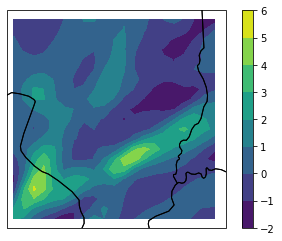

In [71]:
%matplotlib inline

skip=(slice(None,None,1),slice(None,None,1))

map_crs = ccrs.LambertConformal(central_longitude = -95, central_latitude = 25, standard_parallels = (25, 25))
data_crs = ccrs.PlateCarree()

#skip=(slice(None,None,6),slice(None,None,6))

fig = plt.figure(1)
ax = plt.subplot(1, 1, 1, projection = map_crs)
ax.set_extent([lon[fblat:ftlat,fblon:ftlon].min(), lon[fblat:ftlat,fblon:ftlon].max(), lat[fblat:ftlat,fblon:ftlon].min(), lat[fblat:ftlat,fblon:ftlon].max()], data_crs)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))


#comp_r_smooth = ndimage.gaussian_filter(comp_r, sigma=3.0, order=0)
#im = ax.contourf(lon[lat_ind-10:lat_ind+10,lon_ind-10:lon_ind+10], lat[lat_ind-10:lat_ind+10,lon_ind-10:lon_ind+10], comp_r_smooth[lat_ind-10:lat_ind+10, lon_ind-10:lon_ind+10], transform = data_crs)
# _  = ax.contour(lon, lat, comp_r, transform = data_crs, levels = [35])
#_    = ax.contourf(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon], sbCAPE[blat:tlat, blon:tlon])
#im = ax.contourf(lon[fblat:ftlat,fblon :ftlon ], lat[fblat:ftlat,fblon :ftlon ], t_isobaric[1,fblat:ftlat,fblon :ftlon ], transform = data_crs)
# m2 = ax.contour(lon[fblat:ftlat,fblon :ftlon ], lat[fblat:ftlat,fblon :ftlon ], div[1,fblat:ftlat,fblon :ftlon ], transform = data_crs, colors = 'k')

# plt.scatter(lon1, lat1, transform = data_crs, color = 'k')
# plt.scatter(lon2, lat2, transform = data_crs, color = 'k')
# plt.scatter(lon3, lat3, transform = data_crs, color = 'k')
# plt.scatter(lon4, lat4, transform = data_crs, color = 'k')

#plt.scatter(lon[blat:tlat, blon:tlon][lat_ind_subfield, lon_ind_subfield], lat[blat:tlat, blon:tlon][lat_ind_subfield, lon_ind_subfield], transform = data_crs)

im3 = ax.contourf(lon[fblat:ftlat, fblon:ftlon], lat[fblat:ftlat, fblon:ftlon], -divergence[fblat:ftlat, fblon:ftlon]*10**4, transform = data_crs)
#im2 = ax.contourf(lon, lat, sb_cape, transform = data_crs)
#im3 = ax.contourf(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon], r, transform = data_crs)
#im3 = ax.contourf(lon, lat, np.sqrt((1.944*u3)**2 + (1.944*v3)**2), transform = data_crs)
#_  = ax.quiver(lon[::3, ::3], lat[::3,::3], 1.944*u3[::3, ::3], 1.944*v3[::3,::3], transform = data_crs, scale = 1500)
#im4 = ax.contour(lon, lat, cref[0,:,:], transform = data_crs, levels = [20])
#im3 = ax.contourf(lon, lat, precip, transform = data_crs)
#im3 = ax.contourf(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon], precip[blat:tlat, blon:tlon],transform = data_crs)
#im = ax.contourf(lon, lat, td_s, transform = data_crs)
#im = ax.contourf(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon], srh_03, transform = data_crs)
#im2 = ax.contour(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon] ,precip[blat:tlat, blon:tlon], transform = data_crs, levels = [0.001, 0.002,0.01])
#im = ax.contourf(lon[b, lat, , transform = data_crs)#
#im = ax.contourf(lon[fblat:ftlat,fblon :ftlon], lat[fblat:ftlat,fblon :ftlon], frontogenesis_850[fblat:ftlat,fblon:ftlon], transform = data_crs)#, colors = 'k')
#im = ax.contourf(lon[fblat:ftlat,fblon :ftlon ], lat[fblat:ftlat,fblon :ftlon], vort[fblat:ftlat,fblon :ftlon ], transform = data_crs)
#im  = ax.contourf(lon[fblat:ftlat,fblon :ftlon ], lat[fblat:ftlat,fblon :ftlon ], pot_temp[fblat:ftlat,fblon :ftlon], transform = data_crs)#,colors = 'k')
#plt.scatter(lon[fblat:ftlat, fblon:ftlon][lat_max,lon_max], lat[fblat:ftlat, fblon:ftlon][lat_max, lon_max], transform = data_crs, color = 'g')
#plt.scatter(lon[w], lat[w], transform = data_crs, color = 'k')
#_  = ax.quiver(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon], u6, v6, transform = data_crs, scale = 1000)


# plt.scatter(lon[blat,blon], lat[blat,blon], transform = data_crs, color = 'b')
# plt.scatter(lon[tlat-1,blon], lat[tlat-1,blon], transform = data_crs, color = 'b')
# plt.scatter(lon[tlat-1,tlon-1], lat[tlat-1,tlon-1], transform = data_crs, color = 'b')
# plt.scatter(lon[blat,tlon-1], lat[blat,tlon-1], transform = data_crs, color = 'b')
# plt.scatter(lon[lat_ind,lon_ind], lat[lat_ind, lon_ind], transform = data_crs, color ='k', marker = '*', s = 200)

#plt.scatter(lons, lats, transform = data_crs, color = 'k')

# plt.scatter(lon[fblat, fblon], lat[fblat,fblon ], transform = data_crs, color = 'r')
# plt.scatter(lon[ftlat-1,fblon ], lat[ftlat-1,fblon ], transform = data_crs, color = 'r')
# plt.scatter(lon[ftlat-1,ftlon-1 ], lat[ftlat-1,ftlon-1 ], transform = data_crs, color = 'r')
# plt.scatter(lon[fblat,ftlon-1 ], lat[fblat,ftlon-1 ], transform = data_crs, color = 'r')
#plt.scatter(lons, lats, transform = data_crs, color = 'k')

#plt.scatter(lon[blat:tlat, blon:tlon], lat[blat:tlat, blon:tlon], transform = data_crs, color = 'k')
#plt.scatter(lon[fblat:ftlat,fblon:ftlon], lat[fblat:ftlat,fblon:ftlon], transform = data_crs, color = 'k')

# plt.plot([lon[fblat,fblon], lon[ftlat-1,fblon]], [lat[fblat,fblon], lat[ftlat-1,fblon]], transform = data_crs, color = 'r')
# plt.plot([lon[fblat,fblon], lon[fblat,ftlon-1]], [lat[fblat,fblon], lat[fblat,ftlon-1]], transform = data_crs, color = 'r')
# plt.plot([lon[ftlat-1, ftlon-1], lon[fblat,ftlon-1]], [lat[ftlat-1, ftlon-1], lat[fblat,ftlon-1]], transform = data_crs, color = 'r')
# plt.plot([lon[ftlat-1, ftlon-1], lon[ftlat,fblon]], [lat[ftlat-1, ftlon-1], lat[ftlat-1,fblon]], transform = data_crs, color = 'r')


# plt.plot([lon[blat,blon], lon[tlat-1,blon]], [lat[blat,blon], lat[tlat-1,blon]], transform = data_crs, color = 'b')
# plt.plot([lon[blat,blon], lon[blat,tlon-1]], [lat[blat,blon], lat[blat,tlon-1]], transform = data_crs, color = 'b')
# plt.plot([lon[tlat-1,tlon-1], lon[blat,tlon-1]], [lat[tlat-1, tlon-1], lat[blat,tlon-1]], transform = data_crs, color = 'b')
# plt.plot([lon[tlat-1,tlon-1], lon[tlat-1,blon]], [lat[tlat-1, tlon-1], lat[tlat-1,blon]], transform = data_crs, color = 'b')
# plt.scatter(where_lon, where_lat, transform = data_crs, s= 0.4)
# plt.scatter(mtp1[1], mtp1[0],transform = data_crs, s= 2, color = 'r')
# plt.scatter(mtp2[1], mtp2[0],transform = data_crs, s= 2, color = 'r')
plt.colorbar(im3)



In [47]:
(-divergence[fblat:ftlat, fblon:ftlon]).max()

0.0003389423076923077 <Unit('1 / second')>

In [59]:
comp_r = data['Composite_reflectivity_entire_atmosphere'][0,blat:tlat, blon:tlon]
r = data['Precipitation_rate_surface'][0,blat:tlat, blon:tlon]

r

c = data['Convective_available_potential_energy_surface'][0,:,:]
c

masked_array(
  data=[[2440., 2420., 2390., ..., 1780., 1860., 1930.],
        [2430., 2390., 2370., ..., 1790., 1910., 1990.],
        [2430., 2380., 2360., ..., 1900., 2000., 2020.],
        ...,
        [  40.,   40.,   40., ..., 2590., 2340., 2180.],
        [  40.,   40.,   30., ..., 2720., 2520., 2320.],
        [  30.,   30.,   30., ..., 2800., 2710., 2490.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [ ]:
%matplotlib inline
plt.plot(precip.flatten())

In [ ]:
%matplotlib inline
precip_flat= precip.flatten()
sbcape_flat= sbcape.flatten()

tor_dates[5]


In [ ]:
np.where(mu_cape.flatten()>50)[0].shape